In [1]:
import os
seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
experiment = 'No EMA LSTM Time Series - cyclic'

In [2]:
import requests
import lxml
import datetime as dt
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.utils import compute_class_weight
import tensorflow as tf
from sklearn import preprocessing

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
np.random.seed(seed)
tf.random.set_seed(seed)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)

## Cyclic Stocks

### Singapore Airlines

In [5]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/C6L.SI_data.csv")
print(df.head())

         Date  previous_1d     EMA_12   willr_14      OBV_7  labels
0  2000-01-21    19.000000  19.215335 -37.499990   388000.0     2.0
1  2000-01-24    18.400000  19.089899 -50.000000 -2311000.0     2.0
2  2000-01-25    18.100000  18.937607 -48.780483 -3542000.0     2.0
3  2000-01-26    17.700001  18.747206 -85.714237 -6261000.0     2.0
4  2000-01-27    17.799999  18.601482 -82.142864 -4565000.0     2.0


In [6]:
df.set_index('Date', inplace=True)

In [7]:
df.drop(['EMA_12'], axis='columns', inplace=True)

In [8]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1

In [9]:
X = sequential
X  = np.array(X).reshape(-1, 15, 3)
X.shape

(4725, 15, 3)

In [10]:
v = X.reshape(X.shape[0],15, 3)
v[0]

array([[1.        , 1.        , 1.        ],
       [0.75999985, 0.78504654, 0.79689969],
       [0.64000015, 0.80601767, 0.70426669],
       [0.48000031, 0.17089513, 0.49966137],
       [0.51999969, 0.23230939, 0.62728573],
       [0.6       , 0.35514026, 0.70140718],
       [0.71999969, 0.56213184, 0.83332079],
       [0.51999969, 0.24368262, 0.71510272],
       [0.48000031, 0.20037465, 0.64782903],
       [0.55999985, 0.33794397, 0.70140718],
       [0.35999985, 0.06280271, 0.54255399],
       [0.4       , 0.1967527 , 0.57822259],
       [0.15999985, 0.        , 0.41944465],
       [0.08000031, 0.11630365, 0.18639476],
       [0.        , 0.05751282, 0.        ]])

In [11]:
y = labels
y = np.array(y)
y.shape

(4725,)

In [12]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [13]:
SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
RATIO_TO_PREDICT = "Close"

In [14]:
import time

EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [15]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [16]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [17]:
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa
opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

#tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "LSTM_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    shuffle = True,
    validation_data=(validation_x, validation_y),
    #callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 0 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Epoch 1/200
30/30 [==============================] - 1s 37ms/step - loss: 0.2959 - accuracy: 0.4910 - mse: 0.4762 - weighted_accuracy: 0.3507 - weighted_mse: 0.5318 - val_loss: 0.3005 - val_accuracy: 0.0476 - val_mse: 0.3475 - val_weighted_accuracy: 0.0476 - val_weighted_mse: 0.3475
Epoch 2/200
30/30 [==============================] - 0s 11ms/step - loss: 0.2174 - accuracy: 0.3664 - mse: 0.7283 - weighted_accuracy: 0.4052 - weighted_mse: 0.7319 - val_loss: 0.2909 - val_accuracy: 0.0455 - val_mse: 0.3745 - val_weighted_accuracy: 0.0455 - val_weighted_mse: 0.3745
Epoch 3/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1950 - accuracy: 0.3241 - mse: 0.9419 - weighted_accuracy: 0.4599 - weighted_mse: 0.9382 - val_loss: 0.2790 - val_accuracy: 0.0455 - val_mse: 0.4090 - val_weighted_accuracy: 0.0455 - val_weighted_mse: 0.4090
Epoch 4/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1847 - accuracy: 0.2857 - mse: 1.0902 - weighted_accuracy: 0.4885 - weig

Epoch 30/200
30/30 [==============================] - 0s 11ms/step - loss: 0.1403 - accuracy: 0.4397 - mse: 1.5914 - weighted_accuracy: 0.7040 - weighted_mse: 1.5207 - val_loss: 0.1882 - val_accuracy: 0.3937 - val_mse: 1.4726 - val_weighted_accuracy: 0.3937 - val_weighted_mse: 1.4726
Epoch 31/200
30/30 [==============================] - 0s 11ms/step - loss: 0.1390 - accuracy: 0.4601 - mse: 1.5795 - weighted_accuracy: 0.7134 - weighted_mse: 1.5105 - val_loss: 0.1960 - val_accuracy: 0.3556 - val_mse: 1.6390 - val_weighted_accuracy: 0.3556 - val_weighted_mse: 1.6390
Epoch 32/200
30/30 [==============================] - 0s 12ms/step - loss: 0.1380 - accuracy: 0.4225 - mse: 1.6262 - weighted_accuracy: 0.7070 - weighted_mse: 1.5431 - val_loss: 0.1824 - val_accuracy: 0.4413 - val_mse: 1.4945 - val_weighted_accuracy: 0.4413 - val_weighted_mse: 1.4945
Epoch 33/200
30/30 [==============================] - 0s 11ms/step - loss: 0.1378 - accuracy: 0.4960 - mse: 1.6059 - weighted_accuracy: 0.7135 - 

Epoch 59/200
30/30 [==============================] - 0s 11ms/step - loss: 0.1154 - accuracy: 0.5685 - mse: 2.0404 - weighted_accuracy: 0.7919 - weighted_mse: 2.0087 - val_loss: 0.1870 - val_accuracy: 0.4561 - val_mse: 2.0499 - val_weighted_accuracy: 0.4561 - val_weighted_mse: 2.0499
Epoch 60/200
30/30 [==============================] - 0s 11ms/step - loss: 0.1148 - accuracy: 0.5767 - mse: 2.0374 - weighted_accuracy: 0.8023 - weighted_mse: 2.0043 - val_loss: 0.1875 - val_accuracy: 0.4603 - val_mse: 2.0176 - val_weighted_accuracy: 0.4603 - val_weighted_mse: 2.0176
Epoch 61/200
30/30 [==============================] - 0s 11ms/step - loss: 0.1149 - accuracy: 0.5770 - mse: 2.0436 - weighted_accuracy: 0.8006 - weighted_mse: 2.0149 - val_loss: 0.2007 - val_accuracy: 0.4286 - val_mse: 2.1491 - val_weighted_accuracy: 0.4286 - val_weighted_mse: 2.1491
Epoch 62/200
30/30 [==============================] - 0s 11ms/step - loss: 0.1147 - accuracy: 0.5574 - mse: 2.0648 - weighted_accuracy: 0.7896 - 

Epoch 88/200
30/30 [==============================] - 0s 11ms/step - loss: 0.0950 - accuracy: 0.6714 - mse: 2.6247 - weighted_accuracy: 0.8555 - weighted_mse: 2.6275 - val_loss: 0.1729 - val_accuracy: 0.5598 - val_mse: 2.4208 - val_weighted_accuracy: 0.5598 - val_weighted_mse: 2.4208
Epoch 89/200
30/30 [==============================] - 0s 11ms/step - loss: 0.0930 - accuracy: 0.6722 - mse: 2.6399 - weighted_accuracy: 0.8596 - weighted_mse: 2.6487 - val_loss: 0.1662 - val_accuracy: 0.6021 - val_mse: 2.6940 - val_weighted_accuracy: 0.6021 - val_weighted_mse: 2.6940
Epoch 90/200
30/30 [==============================] - 0s 11ms/step - loss: 0.0947 - accuracy: 0.6669 - mse: 2.7065 - weighted_accuracy: 0.8557 - weighted_mse: 2.7461 - val_loss: 0.1838 - val_accuracy: 0.5386 - val_mse: 2.7527 - val_weighted_accuracy: 0.5386 - val_weighted_mse: 2.7527
Epoch 91/200
30/30 [==============================] - 0s 11ms/step - loss: 0.0935 - accuracy: 0.7037 - mse: 2.6255 - weighted_accuracy: 0.8600 - 

Epoch 117/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0774 - accuracy: 0.7593 - mse: 3.4197 - weighted_accuracy: 0.9007 - weighted_mse: 3.4443 - val_loss: 0.1761 - val_accuracy: 0.6212 - val_mse: 3.6502 - val_weighted_accuracy: 0.6212 - val_weighted_mse: 3.6502
Epoch 118/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0744 - accuracy: 0.7384 - mse: 3.4863 - weighted_accuracy: 0.8930 - weighted_mse: 3.5116 - val_loss: 0.1540 - val_accuracy: 0.6974 - val_mse: 3.5770 - val_weighted_accuracy: 0.6974 - val_weighted_mse: 3.5770
Epoch 119/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0762 - accuracy: 0.7585 - mse: 3.4669 - weighted_accuracy: 0.8930 - weighted_mse: 3.4960 - val_loss: 0.1865 - val_accuracy: 0.5915 - val_mse: 3.7725 - val_weighted_accuracy: 0.5915 - val_weighted_mse: 3.7725
Epoch 120/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0728 - accuracy: 0.7733 - mse: 3.5663 - weighted_accuracy: 0.9077 - 

Epoch 146/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0611 - accuracy: 0.8196 - mse: 4.5663 - weighted_accuracy: 0.9302 - weighted_mse: 4.5261 - val_loss: 0.1787 - val_accuracy: 0.6825 - val_mse: 4.8455 - val_weighted_accuracy: 0.6825 - val_weighted_mse: 4.8455
Epoch 147/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0596 - accuracy: 0.8206 - mse: 4.5457 - weighted_accuracy: 0.9250 - weighted_mse: 4.4889 - val_loss: 0.1916 - val_accuracy: 0.6254 - val_mse: 4.8268 - val_weighted_accuracy: 0.6254 - val_weighted_mse: 4.8268
Epoch 148/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0600 - accuracy: 0.8220 - mse: 4.6491 - weighted_accuracy: 0.9255 - weighted_mse: 4.5733 - val_loss: 0.1758 - val_accuracy: 0.7048 - val_mse: 5.0166 - val_weighted_accuracy: 0.7048 - val_weighted_mse: 5.0166
Epoch 149/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0597 - accuracy: 0.8135 - mse: 4.6374 - weighted_accuracy: 0.9261 - 

Epoch 175/200
30/30 [==============================] - 0s 8ms/step - loss: 0.0476 - accuracy: 0.8717 - mse: 5.9132 - weighted_accuracy: 0.9511 - weighted_mse: 5.5993 - val_loss: 0.1984 - val_accuracy: 0.6974 - val_mse: 6.0067 - val_weighted_accuracy: 0.6974 - val_weighted_mse: 6.0067
Epoch 176/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0498 - accuracy: 0.8497 - mse: 6.0218 - weighted_accuracy: 0.9394 - weighted_mse: 5.7571 - val_loss: 0.2165 - val_accuracy: 0.6497 - val_mse: 5.7900 - val_weighted_accuracy: 0.6497 - val_weighted_mse: 5.7900
Epoch 177/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0477 - accuracy: 0.8622 - mse: 6.0960 - weighted_accuracy: 0.9384 - weighted_mse: 5.8200 - val_loss: 0.2145 - val_accuracy: 0.6624 - val_mse: 5.8346 - val_weighted_accuracy: 0.6624 - val_weighted_mse: 5.8346
Epoch 178/200
30/30 [==============================] - 0s 8ms/step - loss: 0.0508 - accuracy: 0.8442 - mse: 6.0420 - weighted_accuracy: 0.9373 - 

In [18]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.21469102799892426
Test accuracy: 0.7333333492279053


In [19]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-2.6677337  -6.4364605   2.4945192 ]
 [-1.6393639  -2.5840278   0.788955  ]
 [-4.9615135  -1.7724898   1.7050766 ]
 ...
 [-4.924771   -2.1716459   2.443744  ]
 [-3.5305438  -3.9613345   2.725548  ]
 [-3.414826   -0.671077    0.50187355]]


Counter({2: 758, 0: 77, 1: 110})

In [20]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 859, 0: 43, 1: 43})

In [21]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 945
actual predicted buys: 7
actual buys but predicted sell: 0
actual buys but predicted hold: 36
actual sells but predicted buy: 1
actual predicted sells: 3
actual sells but predicted hold: 39
actual holds but predicted buy: 102
actual holds but predicted sell: 74
actual predicted holds: 683
Percentage buys correct: 16.27906976744186%
Percentage sells correct: 6.976744186046512%
Percentage holds correct: 79.51105937136205%
actual buys: 43
actual sells: 43
actual holds: 859


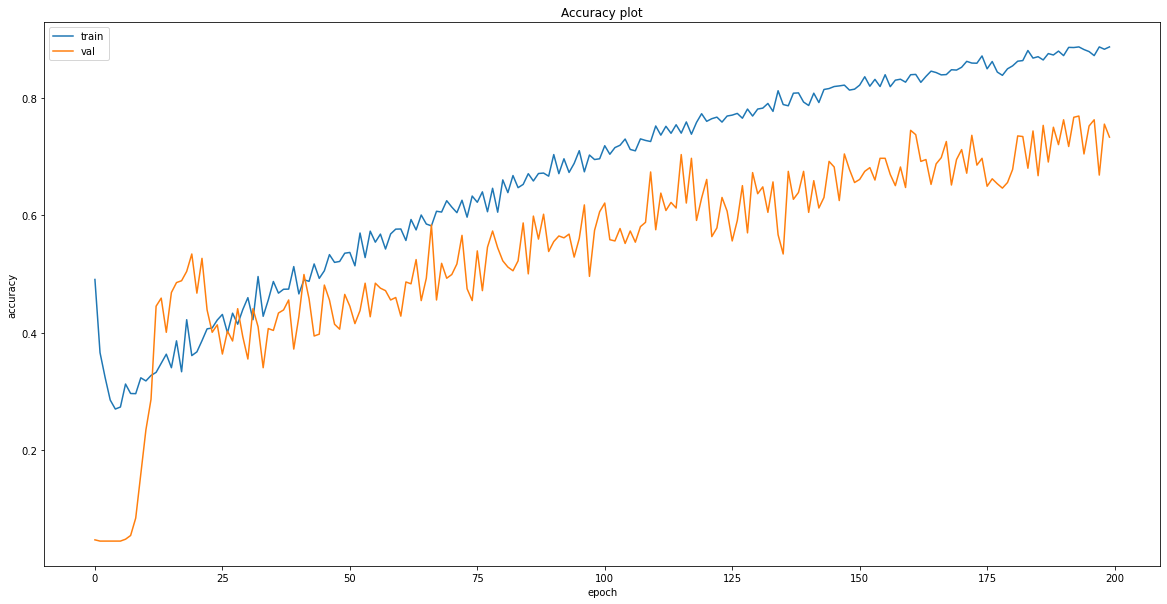

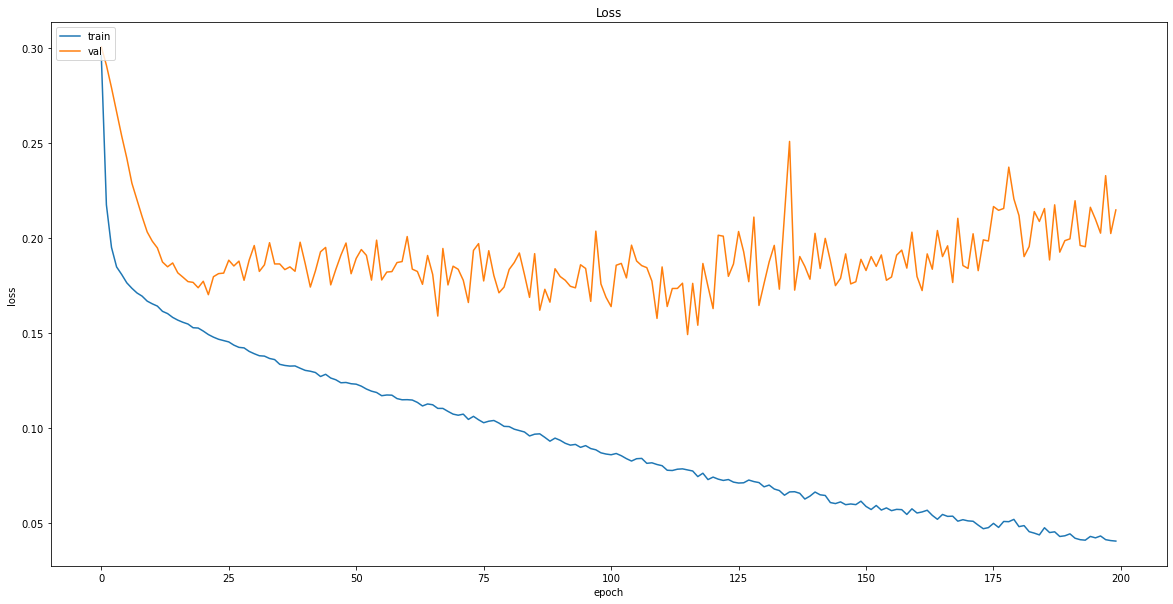

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [23]:
# Save model
model.save("models/{}".format('Singapore_Airlines_time_series_lstm_buy_hold_sell_no_ema.model'))

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: models/Singapore_Airlines_time_series_lstm_buy_hold_sell_no_ema.model\assets


### Test Performance

### non-recession

In [24]:
column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
log  = pd.DataFrame(columns = column_names)
logger = []

In [25]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/C6L.SI_data_test.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d    EMA_12   willr_14      OBV_7  labels
Date                                                           
2019-01-21         9.59  9.538960 -32.758553  6890900.0     2.0
2019-01-22         9.63  9.552966 -25.862007  7759500.0     2.0
2019-01-23         9.61  9.561740 -29.310362  7108100.0     1.0
2019-01-24         9.50  9.552242 -48.275822  6126400.0     2.0
2019-01-25         9.74  9.581128  -8.888884  8160300.0     2.0


In [26]:
df.drop(['EMA_12'], axis='columns', inplace=True)

In [27]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1

In [28]:
X = sequential
X  = np.array(X).reshape(-1, 15, 3)
y = labels
y = np.array(y)
X.shape

(218, 15, 3)

In [29]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [30]:
model = tf.keras.models.load_model("models/Singapore_Airlines_time_series_lstm_buy_hold_sell_no_ema.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]);logger.append(score[1])

7/7 [==============================] - 0s 4ms/step - loss: 0.1564 - accuracy: 0.7569 - mean_squared_error: 6.8672 - weighted_accuracy: 0.7569 - weighted_mean_squared_error: 6.8672
Test loss: 0.15635792911052704
Test accuracy: 0.7568807601928711


In [31]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 171, 0: 25, 1: 22})

In [32]:
actual = [np.argmax(i, axis=None, out=None) for i in y]
Counter(actual)

Counter({2: 200, 0: 9, 1: 9})

In [33]:
df = pd.read_csv("data/cyclic_tickers/initial_indicators/C6L.SI_data_test.csv")
df.set_index('Date', inplace=True)

In [34]:
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df = df.iloc[13:]
df['predictions'] = predictions
df['actual'] = actual
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2019-02-08,9.76,9.644474,-45.454598,5084100.0,2.0,2,2
2019-02-11,9.71,9.662247,-15.151533,6464788.0,2.0,2,2
2019-02-12,9.65,9.669594,-30.303065,5675088.0,2.0,2,2
2019-02-13,9.73,9.666579,-48.484962,4337188.0,2.0,2,2
2019-02-14,9.87,9.676336,-32.000351,5826588.0,2.0,2,2


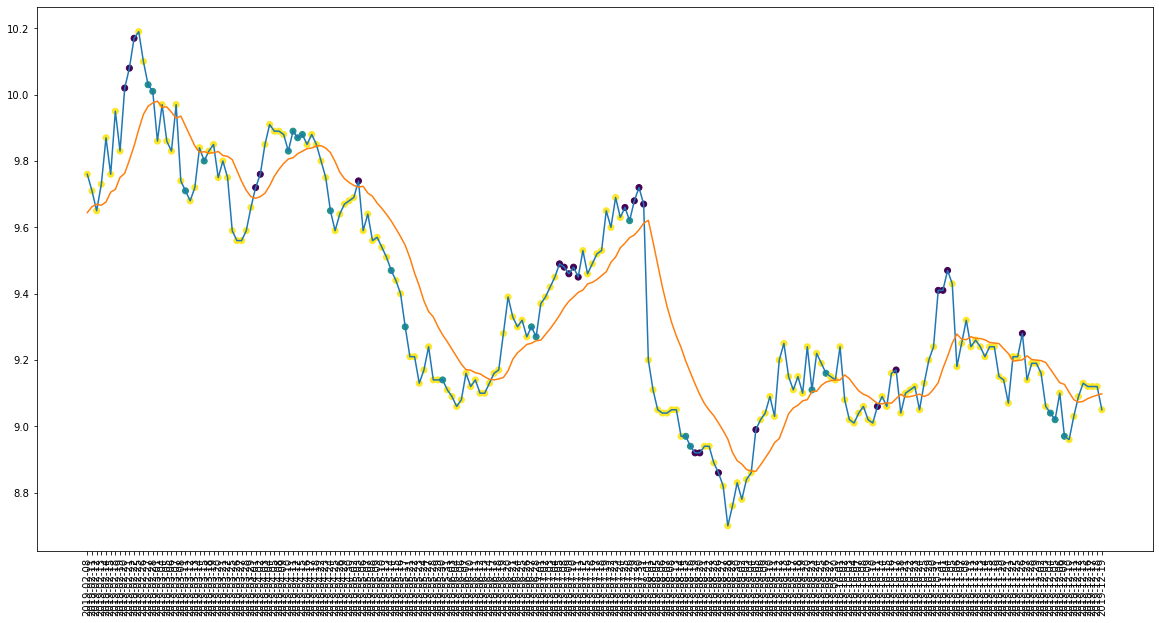

In [35]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [36]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold));logger.append(str(100*buy_buy/buy) + "%");logger.append(str(100*sell_sell/sell) + "%");logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 218
actual predicted buys: 3
actual buys but predicted sell: 0
actual buys but predicted hold: 6
actual sells but predicted buy: 0
actual predicted sells: 3
actual sells but predicted hold: 6
actual holds but predicted buy: 19
actual holds but predicted sell: 22
actual predicted holds: 159
Percentage buys correct: 33.333333333333336%
Percentage sells correct: 33.333333333333336%
Percentage holds correct: 79.5%
actual buys: 9
actual sells: 9
actual holds: 200


In [37]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%");logger.append(str(100*correct_minima/buy) + "%"); logger.append(str(100*correct_maxima/sell) + "%"); logger.append(str(100*correct_hold/hold) + "%")

[9.649999618530273, 9.710000038146973, 9.729999542236328, 9.760000228881836, 9.760000228881836, 9.829999923706056, 9.869999885559082, 9.949999809265137, 10.020000457763672]
[9.829999923706056, 9.949999809265137, 10.010000228881836, 10.020000457763672, 10.029999732971193, 10.079999923706056, 10.100000381469727, 10.170000076293944, 10.1899995803833]
Percentage buys correct: 54.54545454545455%
Percentage sells correct: 60.0%
Percentage holds correct: 80.11695906432749%


In [38]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%');logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $10.029999732971193
Shares owned at the moment: 994
Cash capital at the moment: $2.763261156556837


Stop Loss Activated!

Share price: $9.739999771118164
Shares owned at the moment: 0
Cash capital at the moment: $9657.69874427366


Share price: $9.710000038146973
Shares owned at the moment: 991
Cash capital at the moment: $8.626528866050649


Stop Loss Activated!

Share price: $9.4399995803833
Shares owned at the moment: 0
Cash capital at the moment: $9337.939754169462


Share price: $9.300000190734863
Shares owned at the moment: 1001
Cash capital at the moment: $3.038987718817225


Stop Loss Activated!

Share price: $9.039999961853027
Shares owned at the moment: 0
Cash capital at the moment: $9027.194089638706


Share price: $8.970000267028809
Shares owned at the moment: 1003
Cash capital at the moment: $5.542318572277509


Stop Loss Activated!

Share price: $8.699999809265138
Shares owned at the moment: 0
Cash capital at the moment: $8707.645352791305


Share price: $9.

In [39]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%');logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $9222.27618237376
profit gained: -7.777238176262399%


In [40]:
df_length = len(log)
log.loc[df_length] = logger
log.head(20)

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.756881,33.333333333333336%,33.333333333333336%,79.5%,54.54545454545455%,60.0%,80.11695906432749%,-13.971269578518914%,-7.777238176262399%


### Recession

In [41]:
logger = []

In [42]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/C6L.SI_data_test2.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d    EMA_12   willr_14      OBV_7  labels
Date                                                           
2020-01-22         8.84  8.979182 -96.551645  -851200.0     2.0
2020-01-23         8.93  8.971615 -65.517105  1644900.0     2.0
2020-01-24         8.85  8.952905 -92.307523  -246900.0     2.0
2020-01-28         8.82  8.932458 -75.000000 -1718200.0     2.0
2020-01-29         8.56  8.875157 -86.885115 -5499900.0     2.0


In [43]:
df.drop(['EMA_12'], axis='columns', inplace=True)

In [44]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1

In [45]:
X = sequential
X  = np.array(X).reshape(-1, 15, 3)
y = labels
y = np.array(y)
X.shape

(215, 15, 3)

In [46]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [47]:
model = tf.keras.models.load_model("models/Singapore_Airlines_time_series_lstm_buy_hold_sell_no_ema.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]);logger.append(score[1])

7/7 [==============================] - 0s 4ms/step - loss: 0.1805 - accuracy: 0.7256 - mean_squared_error: 7.6431 - weighted_accuracy: 0.7256 - weighted_mean_squared_error: 7.6431
Test loss: 0.18050570785999298
Test accuracy: 0.7255814075469971


In [48]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 169, 1: 35, 0: 11})

In [49]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [50]:
df = pd.read_csv("data/cyclic_tickers/initial_indicators/C6L.SI_data_test2.csv")
df.set_index('Date', inplace=True)

In [51]:
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df = df.iloc[13:]
df['predictions'] = predictions
df['actual'] = actual
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2020-02-11,8.53,8.641035,-89.830440,-3476200.0,2.0,2,2
2020-02-12,8.64,8.623953,-86.440694,-2356000.0,2.0,2,2
2020-02-13,8.59,8.626421,-61.224363,-575600.0,2.0,2,2
2020-02-14,8.62,8.620818,-64.102508,-2132700.0,2.0,2,2
2020-02-17,8.66,8.620692,-45.161340,-798700.0,2.0,2,2


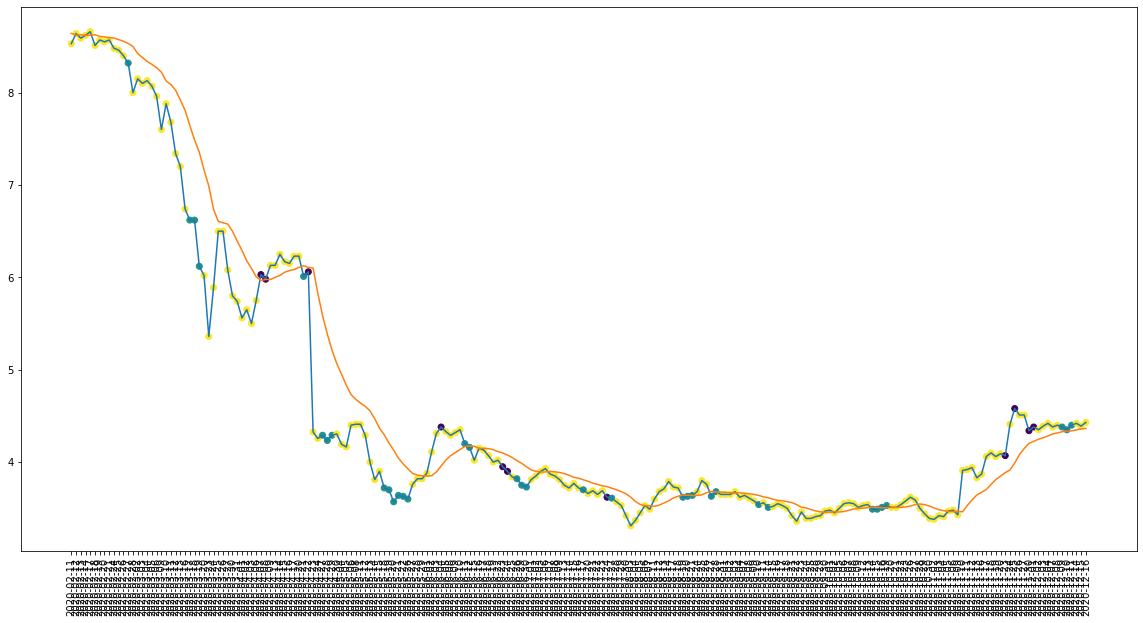

In [52]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [53]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold));logger.append(str(100*buy_buy/buy) + "%");logger.append(str(100*sell_sell/sell) + "%");logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 215
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 6
actual sells but predicted buy: 0
actual predicted sells: 0
actual sells but predicted hold: 9
actual holds but predicted buy: 33
actual holds but predicted sell: 11
actual predicted holds: 154
Percentage buys correct: 25.0%
Percentage sells correct: 0.0%
Percentage holds correct: 77.77777777777777%
actual buys: 8
actual sells: 9
actual holds: 198


In [54]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%");logger.append(str(100*correct_minima/buy) + "%"); logger.append(str(100*correct_maxima/sell) + "%"); logger.append(str(100*correct_hold/hold) + "%")

[8.510000228881836, 8.529999732971191, 8.550000190734862, 8.569999694824219, 8.569999694824219, 8.590000152587889, 8.619999885559082, 8.640000343322754, 8.659999847412111]
[8.0, 8.149999618530272, 8.319999694824219, 8.399999618530272, 8.460000038146973, 8.479999542236326, 8.550000190734862, 8.569999694824219, 8.569999694824219]
Percentage buys correct: 65.71428571428571%
Percentage sells correct: 36.36363636363637%
Percentage holds correct: 87.57396449704142%


In [55]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%');logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $8.319999694824219
Shares owned at the moment: 1198
Cash capital at the moment: $5.230126605987607


Stop Loss Activated!

Share price: $8.0
Shares owned at the moment: 0
Cash capital at the moment: $9562.874126605988


Share price: $6.619999885559082
Shares owned at the moment: 1440
Cash capital at the moment: $3.859091854095823


Stop Loss Activated!

Share price: $6.119999885559082
Shares owned at the moment: 0
Cash capital at the moment: $8792.42372751236


Share price: $6.119999885559082
Shares owned at the moment: 1432
Cash capital at the moment: $4.483331842422558


Stop Loss Activated!

Share price: $5.360000133514403
Shares owned at the moment: 0
Cash capital at the moment: $7658.895842509269


Share price: $6.010000228881836
Shares owned at the moment: 1270
Cash capital at the moment: $5.205626029966879


Stop Loss Activated!

Share price: $4.326051235198976
Shares owned at the moment: 0
Cash capital at the moment: $5484.181960793734


Share price: $4.29082298278

In [56]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%');logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $5165.4369528948055
profit gained: -48.34563047105195%


In [57]:
df_length = len(log)
log.loc[df_length] = logger
log.head(20)

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.756881,33.333333333333336%,33.333333333333336%,79.5%,54.54545454545455%,60.0%,80.11695906432749%,-13.971269578518914%,-7.777238176262399%
1,0.725581,25.0%,0.0%,77.77777777777777%,65.71428571428571%,36.36363636363637%,87.57396449704142%,-51.61628959737723%,-48.34563047105195%


### OCBC Bank

In [58]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/O39.SI_data.csv")
print(df.head())

         Date  previous_1d    EMA_12   willr_14      OBV_7  labels
0  2000-01-21     6.793788  7.018572 -90.000010 -1965914.0     2.0
1  2000-01-24     6.890842  6.998922 -77.777802  6276910.0     2.0
2  2000-01-25     6.793788  6.967363 -85.714286  -511055.0     2.0
3  2000-01-26     6.745261  6.933193 -86.666549 -7435027.0     2.0
4  2000-01-27     6.890842  6.926678 -66.666601 -3725757.0     2.0


In [59]:
df.set_index('Date', inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2000-01-21,6.793788,7.018572,-90.000010,-1965914.0,2.0
2000-01-24,6.890842,6.998922,-77.777802,6276910.0,2.0
2000-01-25,6.793788,6.967363,-85.714286,-511055.0,2.0
2000-01-26,6.745261,6.933193,-86.666549,-7435027.0,2.0
2000-01-27,6.890842,6.926678,-66.666601,-3725757.0,2.0


In [60]:
df.drop(['EMA_12'], axis='columns', inplace=True)

In [61]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1

In [62]:
X = sequential
X  = np.array(X).reshape(-1, 15, 3)
X.shape

(4789, 15, 3)

In [63]:
y = labels
y = np.array(y)

In [64]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [65]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [66]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [67]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [68]:
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa
opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

#tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "LSTM_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    shuffle = True,
    validation_data=(validation_x, validation_y),
    #callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Epoch 1/200
30/30 [==============================] - 1s 32ms/step - loss: 0.2847 - accuracy: 0.5056 - mse: 0.4813 - weighted_accuracy: 0.3546 - weighted_mse: 0.5489 - val_loss: 0.3003 - val_accuracy: 0.0428 - val_mse: 0.3482 - val_weighted_accuracy: 0.0428 - val_weighted_mse: 0.3482
Epoch 2/200
30/30 [==============================] - 0s 8ms/step - loss: 0.2109 - accuracy: 0.3158 - mse: 0.7888 - weighted_accuracy: 0.4586 - weighted_mse: 0.7807 - val_loss: 0.2912 - val_accuracy: 0.0418 - val_mse: 0.3771 - val_weighted_accuracy: 0.0418 - val_weighted_mse: 0.3771
Epoch 3/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1916 - accuracy: 0.2738 - mse: 0.9901 - weighted_accuracy: 0.4894 - weighted_mse: 0.9688 - val_loss: 0.2793 - val_accuracy: 0.0418 - val_mse: 0.4134 - val_weighted_accuracy: 0.0418 - val_weighted_mse: 0.4134
Epoch 4/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1811 - accuracy: 0.2383 - mse: 1.1387 - weighted_accuracy: 0.5277 - weighte

Epoch 30/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1284 - accuracy: 0.4002 - mse: 1.8491 - weighted_accuracy: 0.7473 - weighted_mse: 1.7806 - val_loss: 0.1915 - val_accuracy: 0.3695 - val_mse: 1.8175 - val_weighted_accuracy: 0.3695 - val_weighted_mse: 1.8175
Epoch 31/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1286 - accuracy: 0.4364 - mse: 1.8399 - weighted_accuracy: 0.7590 - weighted_mse: 1.7799 - val_loss: 0.1881 - val_accuracy: 0.3998 - val_mse: 1.8411 - val_weighted_accuracy: 0.3998 - val_weighted_mse: 1.8411
Epoch 32/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1271 - accuracy: 0.4495 - mse: 1.8533 - weighted_accuracy: 0.7575 - weighted_mse: 1.7985 - val_loss: 0.1866 - val_accuracy: 0.4081 - val_mse: 1.9578 - val_weighted_accuracy: 0.4081 - val_weighted_mse: 1.9578
Epoch 33/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1262 - accuracy: 0.4474 - mse: 1.9008 - weighted_accuracy: 0.7567 - weig

Epoch 59/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1037 - accuracy: 0.5808 - mse: 2.4982 - weighted_accuracy: 0.8302 - weighted_mse: 2.5496 - val_loss: 0.1890 - val_accuracy: 0.4864 - val_mse: 2.5879 - val_weighted_accuracy: 0.4864 - val_weighted_mse: 2.5879
Epoch 60/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1045 - accuracy: 0.6082 - mse: 2.4900 - weighted_accuracy: 0.8255 - weighted_mse: 2.5526 - val_loss: 0.1884 - val_accuracy: 0.4906 - val_mse: 2.7268 - val_weighted_accuracy: 0.4906 - val_weighted_mse: 2.7268
Epoch 61/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1032 - accuracy: 0.6098 - mse: 2.5551 - weighted_accuracy: 0.8349 - weighted_mse: 2.6289 - val_loss: 0.1781 - val_accuracy: 0.5146 - val_mse: 2.4375 - val_weighted_accuracy: 0.5146 - val_weighted_mse: 2.4375
Epoch 62/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1014 - accuracy: 0.6202 - mse: 2.5448 - weighted_accuracy: 0.8375 - weig

Epoch 88/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0811 - accuracy: 0.7173 - mse: 3.3824 - weighted_accuracy: 0.8855 - weighted_mse: 3.5631 - val_loss: 0.1535 - val_accuracy: 0.6566 - val_mse: 3.6212 - val_weighted_accuracy: 0.6566 - val_weighted_mse: 3.6212
Epoch 89/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0810 - accuracy: 0.7150 - mse: 3.4271 - weighted_accuracy: 0.8849 - weighted_mse: 3.6235 - val_loss: 0.1655 - val_accuracy: 0.6138 - val_mse: 3.8119 - val_weighted_accuracy: 0.6138 - val_weighted_mse: 3.8119
Epoch 90/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0808 - accuracy: 0.7364 - mse: 3.4773 - weighted_accuracy: 0.8893 - weighted_mse: 3.6849 - val_loss: 0.1926 - val_accuracy: 0.5595 - val_mse: 3.6203 - val_weighted_accuracy: 0.5595 - val_weighted_mse: 3.6203
Epoch 91/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0810 - accuracy: 0.7181 - mse: 3.5097 - weighted_accuracy: 0.8862 - weig

Epoch 117/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0623 - accuracy: 0.8087 - mse: 4.6847 - weighted_accuracy: 0.9227 - weighted_mse: 4.8693 - val_loss: 0.1721 - val_accuracy: 0.6775 - val_mse: 4.5740 - val_weighted_accuracy: 0.6775 - val_weighted_mse: 4.5740
Epoch 118/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0619 - accuracy: 0.8058 - mse: 4.7174 - weighted_accuracy: 0.9236 - weighted_mse: 4.9355 - val_loss: 0.1630 - val_accuracy: 0.6889 - val_mse: 5.0286 - val_weighted_accuracy: 0.6889 - val_weighted_mse: 5.0286
Epoch 119/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0588 - accuracy: 0.8040 - mse: 4.7808 - weighted_accuracy: 0.9212 - weighted_mse: 5.0123 - val_loss: 0.1537 - val_accuracy: 0.7109 - val_mse: 5.2864 - val_weighted_accuracy: 0.7109 - val_weighted_mse: 5.2864
Epoch 120/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0604 - accuracy: 0.8256 - mse: 4.8783 - weighted_accuracy: 0.9327 - 

Epoch 146/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0472 - accuracy: 0.8658 - mse: 6.2243 - weighted_accuracy: 0.9492 - weighted_mse: 6.2768 - val_loss: 0.1780 - val_accuracy: 0.7077 - val_mse: 6.6741 - val_weighted_accuracy: 0.7077 - val_weighted_mse: 6.6741
Epoch 147/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0466 - accuracy: 0.8606 - mse: 6.3182 - weighted_accuracy: 0.9399 - weighted_mse: 6.3415 - val_loss: 0.1943 - val_accuracy: 0.6868 - val_mse: 6.5484 - val_weighted_accuracy: 0.6868 - val_weighted_mse: 6.5484
Epoch 148/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0476 - accuracy: 0.8643 - mse: 6.3392 - weighted_accuracy: 0.9504 - weighted_mse: 6.3619 - val_loss: 0.1752 - val_accuracy: 0.7223 - val_mse: 6.9439 - val_weighted_accuracy: 0.7223 - val_weighted_mse: 6.9439
Epoch 149/200
30/30 [==============================] - 0s 8ms/step - loss: 0.0478 - accuracy: 0.8606 - mse: 6.4252 - weighted_accuracy: 0.9379 - 

Epoch 175/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0367 - accuracy: 0.8974 - mse: 8.1471 - weighted_accuracy: 0.9607 - weighted_mse: 7.8765 - val_loss: 0.1903 - val_accuracy: 0.7662 - val_mse: 9.2928 - val_weighted_accuracy: 0.7662 - val_weighted_mse: 9.2928
Epoch 176/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0391 - accuracy: 0.8922 - mse: 8.3861 - weighted_accuracy: 0.9566 - weighted_mse: 8.1088 - val_loss: 0.1798 - val_accuracy: 0.7850 - val_mse: 8.5558 - val_weighted_accuracy: 0.7850 - val_weighted_mse: 8.5558
Epoch 177/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0386 - accuracy: 0.8883 - mse: 8.2777 - weighted_accuracy: 0.9534 - weighted_mse: 7.9503 - val_loss: 0.2014 - val_accuracy: 0.7662 - val_mse: 8.6674 - val_weighted_accuracy: 0.7662 - val_weighted_mse: 8.6674
Epoch 178/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0366 - accuracy: 0.8979 - mse: 8.4493 - weighted_accuracy: 0.9569 - 

In [69]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1]);logger.append(score[1])

Test loss: 0.20989561080932617
Test accuracy: 0.7755740880966187


In [70]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-3.216733   -6.110207    2.7036033 ]
 [-4.42346    -0.66701895 -0.21769197]
 [-3.9623055  -3.0342553   2.6847668 ]
 ...
 [ 0.14193518 -3.3678718  -0.9069707 ]
 [-1.9655772  -4.295743    1.0955138 ]
 [-0.9783287  -3.9707232   0.8484113 ]]


Counter({2: 804, 0: 80, 1: 74})

In [71]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 874, 1: 40, 0: 44})

In [72]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold));logger.append(str(100*buy_buy/buy) + "%");logger.append(str(100*sell_sell/sell) + "%");logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 958
actual predicted buys: 5
actual buys but predicted sell: 0
actual buys but predicted hold: 35
actual sells but predicted buy: 1
actual predicted sells: 6
actual sells but predicted hold: 37
actual holds but predicted buy: 68
actual holds but predicted sell: 74
actual predicted holds: 732
Percentage buys correct: 12.5%
Percentage sells correct: 13.636363636363637%
Percentage holds correct: 83.75286041189932%
actual buys: 40
actual sells: 44
actual holds: 874


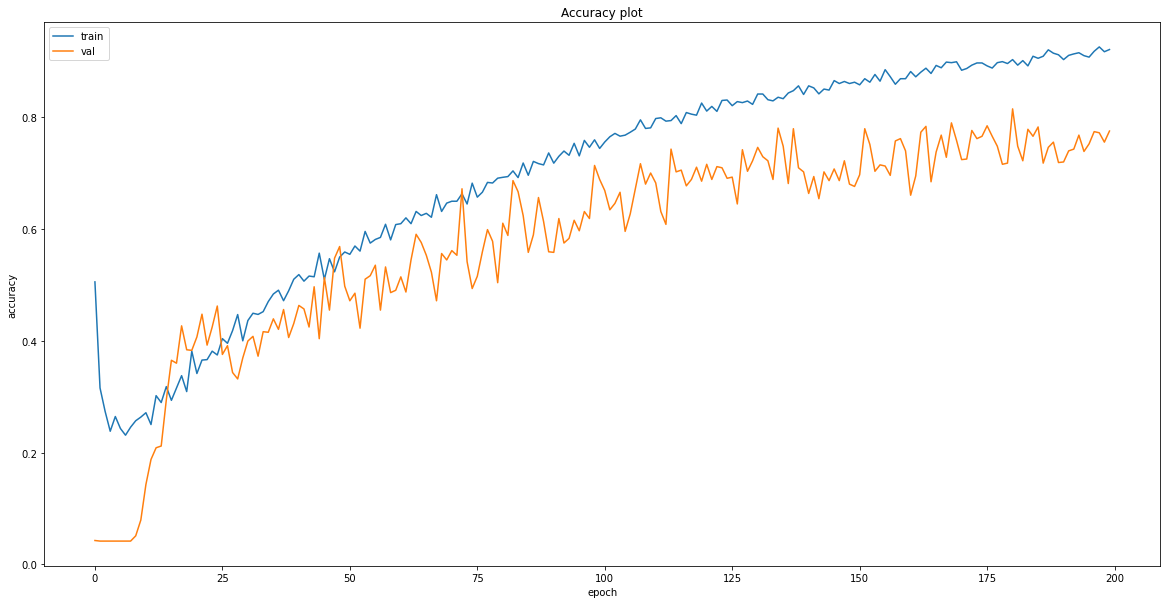

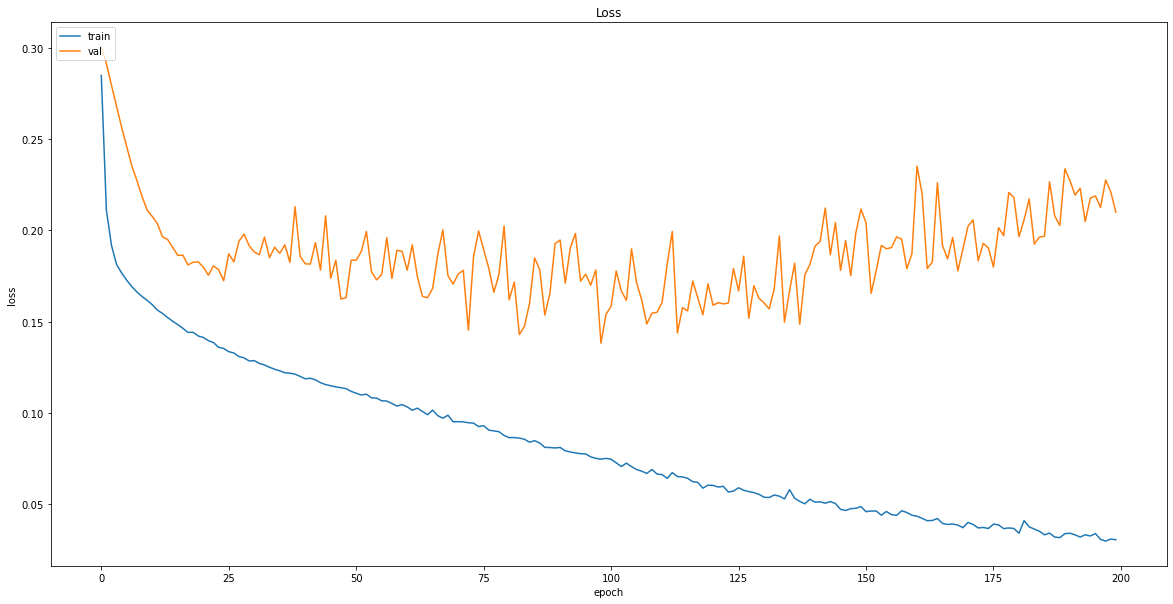

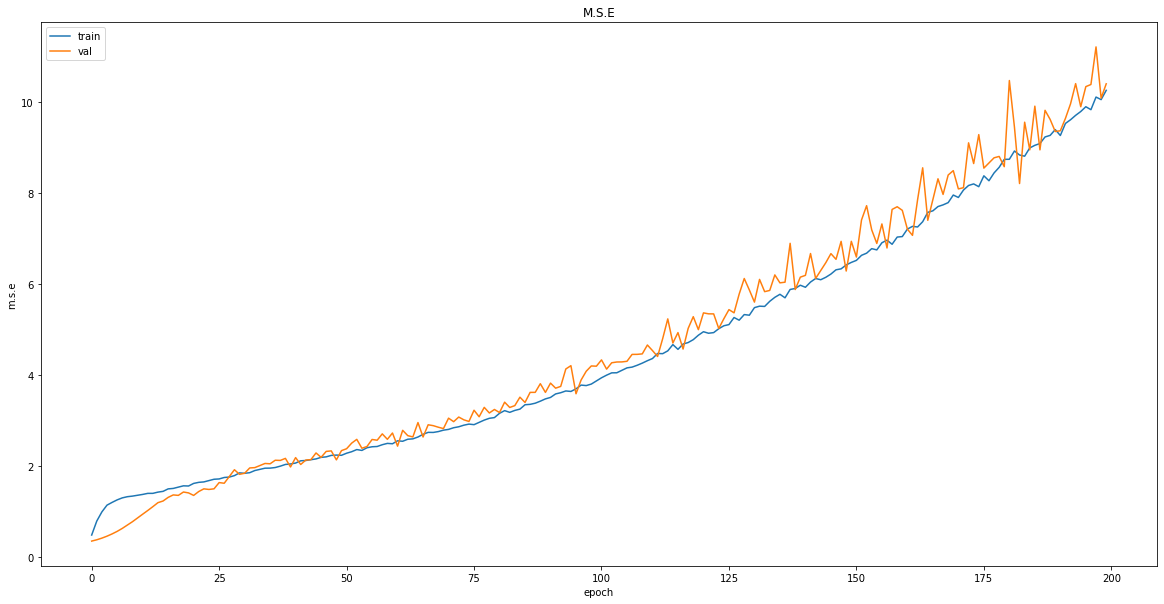

In [73]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('M.S.E')
plt.ylabel('m.s.e')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [74]:
# Save model
model.save("models/{}".format('ocbc_time_series_lstm_buy_hold_sell_no_ema.model'))

INFO:tensorflow:Assets written to: models/ocbc_time_series_lstm_buy_hold_sell_no_ema.model\assets


### Test Performance

### non-recession

In [75]:
logger = []

In [76]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/O39.SI_data_test.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2019-01-21        11.75  11.523654 -10.869606  21160951.0     2.0
2019-01-22        11.73  11.555399 -13.978517  18040951.0     2.0
2019-01-23        11.50  11.546876 -38.709667  14286851.0     1.0
2019-01-24        11.38  11.521203 -51.612890   8454651.0     2.0
2019-01-25        11.41  11.504095 -80.357185  12469051.0     2.0


In [77]:
df.drop(['EMA_12'], axis='columns', inplace=True)

In [78]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1

In [79]:
X = sequential
X  = np.array(X).reshape(-1, 15, 3)
y = labels
y = np.array(y)
X.shape

(218, 15, 3)

In [80]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [81]:
model = tf.keras.models.load_model("models/ocbc_time_series_lstm_buy_hold_sell_no_ema.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]);logger.append(score[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.2392 - accuracy: 0.7385 - mean_squared_error: 11.1227 - weighted_accuracy: 0.7385 - weighted_mean_squared_error: 11.1227
Test loss: 0.23915314674377441
Test accuracy: 0.7385321259498596


In [82]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 174, 0: 22, 1: 22})

In [83]:
actual = [np.argmax(i, axis=None, out=None) for i in y]
Counter(actual)

Counter({2: 201, 0: 9, 1: 8})

In [84]:
df = pd.read_csv("data/cyclic_tickers/initial_indicators/O39.SI_data_test.csv")
df.set_index('Date', inplace=True)

In [85]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2019-02-11,11.53,11.457507,-67.857228,17615658.0,2.0,2,2
2019-02-12,11.49,11.468659,-43.902530,20832858.0,2.0,2,2
2019-02-13,11.65,11.471942,-42.424356,17325458.0,2.0,2,2
2019-02-14,11.68,11.499336,-10.256417,22091358.0,2.0,0,2
2019-02-15,11.52,11.527130,-5.714153,24228358.0,2.0,0,2


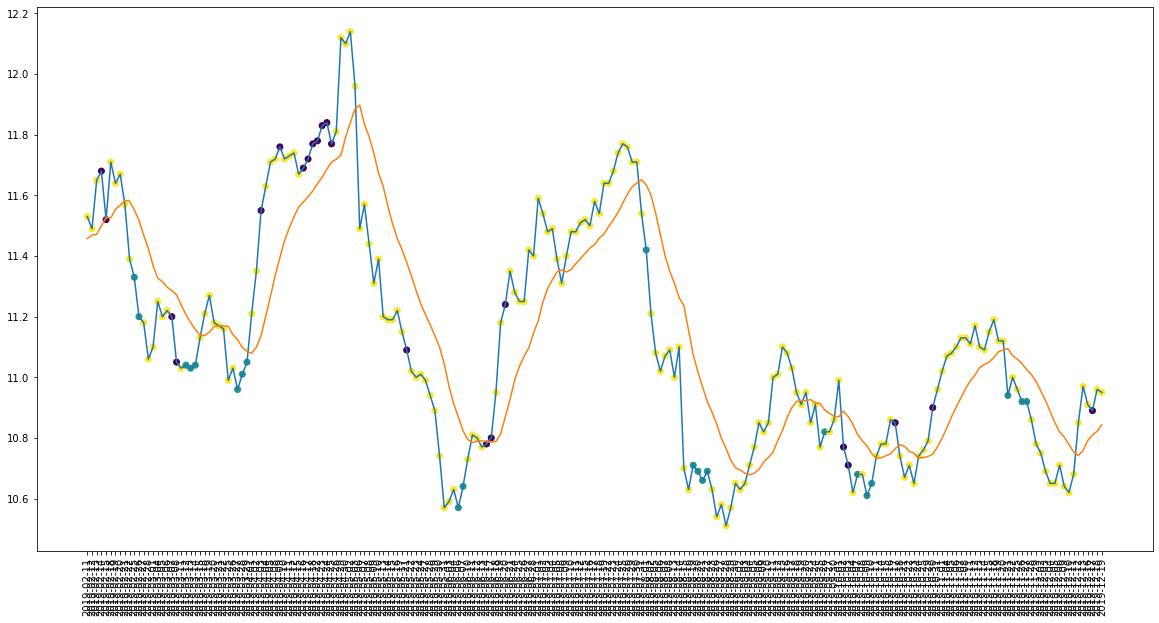

In [86]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

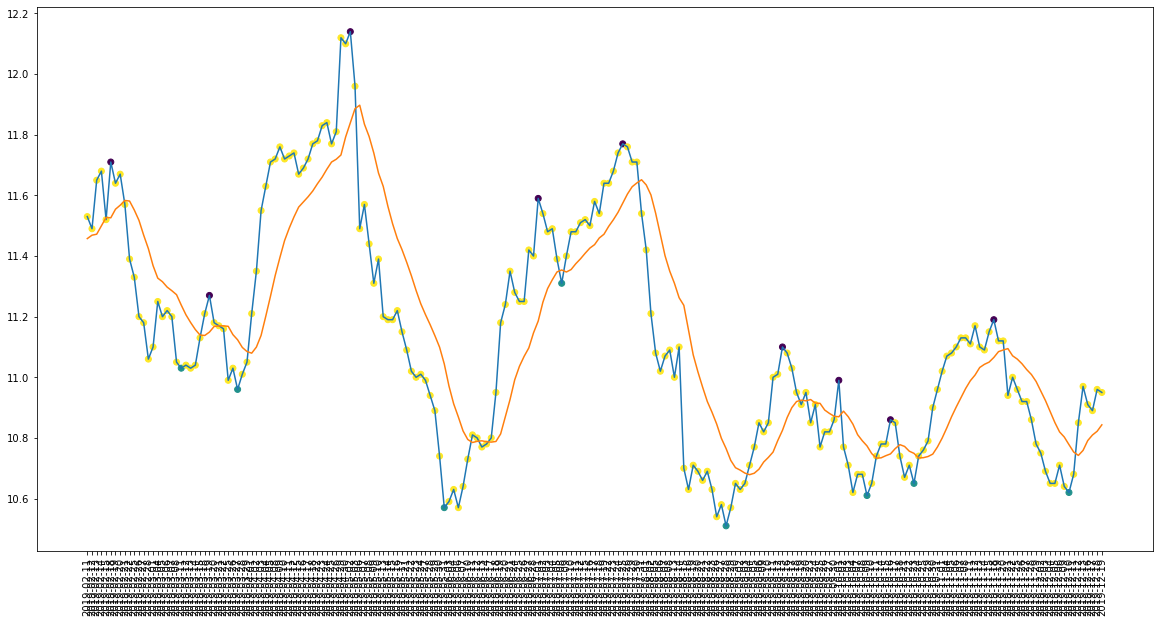

In [87]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [88]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold));logger.append(str(100*buy_buy/buy) + "%");logger.append(str(100*sell_sell/sell) + "%");logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 218
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 6
actual sells but predicted buy: 0
actual predicted sells: 0
actual sells but predicted hold: 9
actual holds but predicted buy: 20
actual holds but predicted sell: 22
actual predicted holds: 159
Percentage buys correct: 25.0%
Percentage sells correct: 0.0%
Percentage holds correct: 79.1044776119403%
actual buys: 8
actual sells: 9
actual holds: 201


In [89]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%");logger.append(str(100*correct_minima/buy) + "%"); logger.append(str(100*correct_maxima/sell) + "%"); logger.append(str(100*correct_hold/hold) + "%")

[11.489999771118164, 11.520000457763672, 11.529999732971193, 11.56999969482422, 11.640000343322756, 11.649999618530273, 11.670000076293945, 11.68000030517578, 11.710000038146973]
[11.0600004196167, 11.100000381469727, 11.18000030517578, 11.199999809265137, 11.329999923706055, 11.390000343322756, 11.56999969482422, 11.640000343322756, 11.670000076293945]
Percentage buys correct: 59.09090909090909%
Percentage sells correct: 36.36363636363637%
Percentage holds correct: 86.1271676300578%


In [90]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%');logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $11.329999923706055
Shares owned at the moment: 880
Cash capital at the moment: $2.1814673233020585


Stop Loss Activated!

Share price: $10.989999771118164
Shares owned at the moment: 0
Cash capital at the moment: $9646.78546646118


Share price: $10.960000038146973
Shares owned at the moment: 877
Cash capital at the moment: $8.432652914283608


Price increase from previously bought: 5.094203991344615%
Share price: $11.550000190734865
Shares owned at the moment: 0
Cash capital at the moment: $10109.927107228756


Share price: $10.56999969482422
Shares owned at the moment: 953
Cash capital at the moment: $9.016071361062131


Price increase from previously bought: 6.04706589176931%
Share price: $11.239999771118164
Shares owned at the moment: 0
Cash capital at the moment: $10691.278623836513


Share price: $11.420000076293945
Shares owned at the moment: 933
Cash capital at the moment: $7.117687458510773


Stop Loss Activated!

Share price: $11.079999923706056
Shares owned at

In [91]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%');logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $9445.467587005614
profit gained: -5.545324129943856%


In [92]:
df_length = len(log)
log.loc[df_length] = logger
log.head(20)

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.756881,33.333333333333336%,33.333333333333336%,79.5%,54.54545454545455%,60.0%,80.11695906432749%,-13.971269578518914%,-7.777238176262399%
1,0.725581,25.0%,0.0%,77.77777777777777%,65.71428571428571%,36.36363636363637%,87.57396449704142%,-51.61628959737723%,-48.34563047105195%
2,0.738532,25.0%,0.0%,79.1044776119403%,59.09090909090909%,36.36363636363637%,86.1271676300578%,4.895464871482818%,-5.545324129943856%


### recession

In [93]:
logger = []

In [94]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/O39.SI_data_test2.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2020-01-22        11.12  11.072811 -24.444379  27489400.0     2.0
2020-01-23        11.19  11.090840  -8.888884  31751200.0     2.0
2020-01-24        11.11  11.093787 -26.666653  27359800.0     2.0
2020-01-28        11.10  11.094743 -28.888715  24699300.0     2.0
2020-01-29        10.90  11.064783 -71.739257  16499235.0     2.0


In [95]:
df.drop(['EMA_12'], axis='columns', inplace=True)

In [96]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1

In [97]:
X = sequential
X  = np.array(X).reshape(-1, 15, 3)
y = labels
y = np.array(y)
X.shape

(215, 15, 3)

In [98]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [99]:
model = tf.keras.models.load_model("models/ocbc_time_series_lstm_buy_hold_sell_no_ema.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]);logger.append(score[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.2117 - accuracy: 0.7953 - mean_squared_error: 10.1658 - weighted_accuracy: 0.7953 - weighted_mean_squared_error: 10.1658
Test loss: 0.21173344552516937
Test accuracy: 0.7953488230705261


In [100]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 175, 0: 15, 1: 25})

In [101]:
actual = [np.argmax(i, axis=None, out=None) for i in y]
Counter(actual)

Counter({2: 193, 0: 10, 1: 12})

In [102]:
df = pd.read_csv("data/cyclic_tickers/initial_indicators/O39.SI_data_test2.csv")
df.set_index('Date', inplace=True)

In [103]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2020-02-12,11.02,10.890637,-80.357049,13333200.0,2.0,2,2
2020-02-13,11.05,10.910539,-32.075322,21593100.0,2.0,2,2
2020-02-14,11.06,10.931995,-15.217324,25962500.0,2.0,2,2
2020-02-17,11.01,10.951688,-13.043361,29610200.0,2.0,0,2
2020-02-18,10.97,10.960659,-23.912967,27996300.0,2.0,2,2


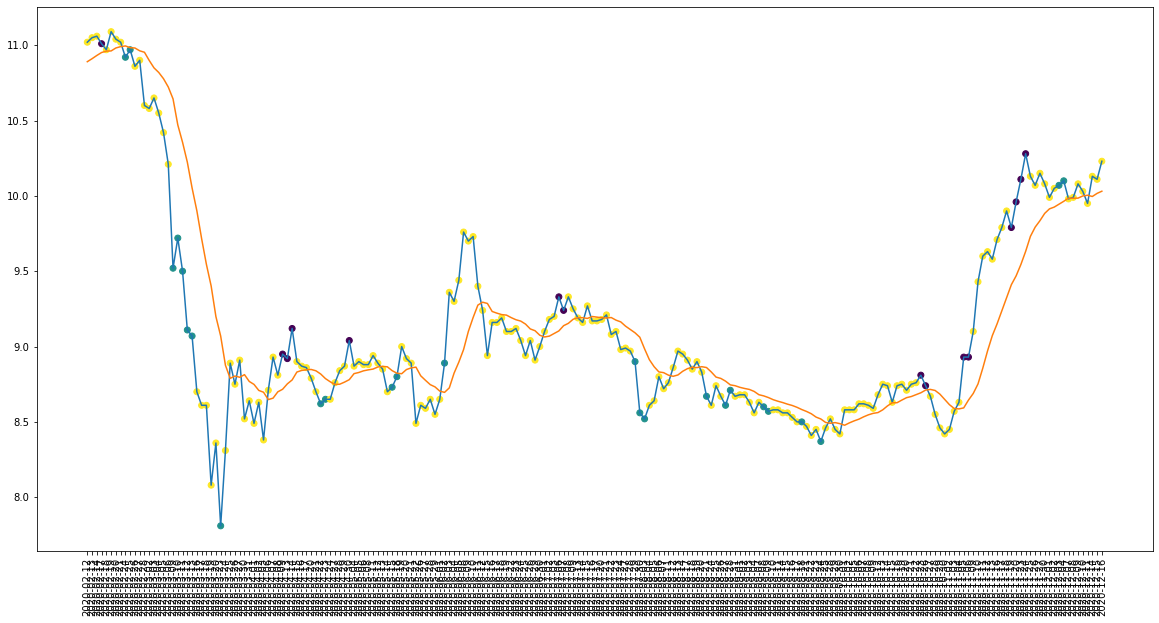

In [104]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

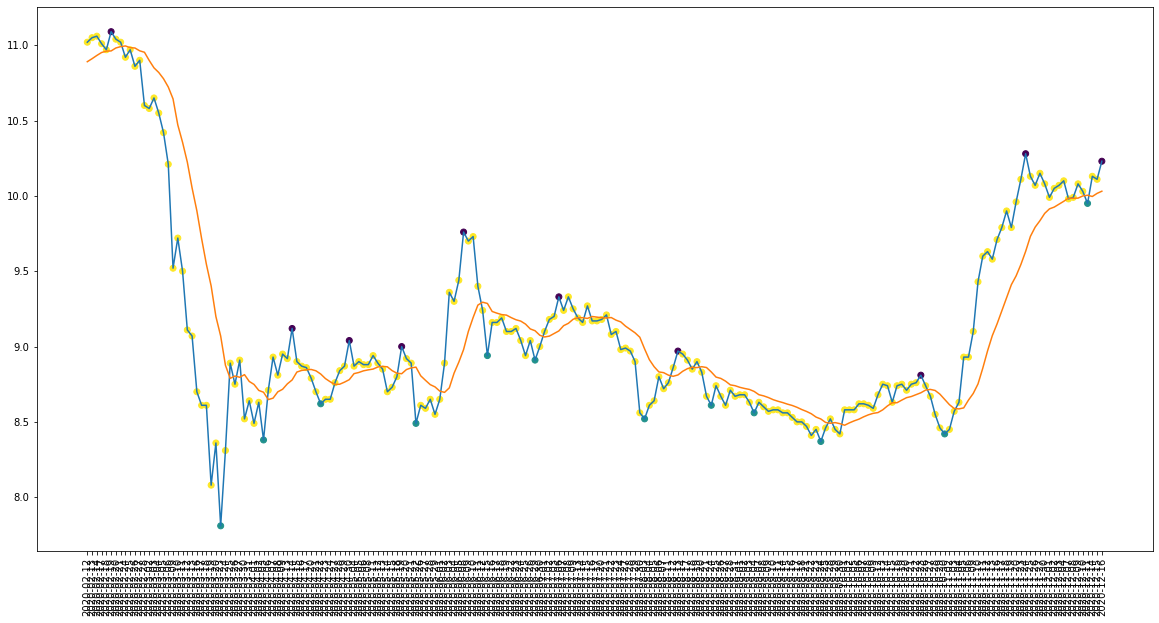

In [105]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [106]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold));logger.append(str(100*buy_buy/buy) + "%");logger.append(str(100*sell_sell/sell) + "%");logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 215
actual predicted buys: 4
actual buys but predicted sell: 0
actual buys but predicted hold: 8
actual sells but predicted buy: 0
actual predicted sells: 5
actual sells but predicted hold: 5
actual holds but predicted buy: 21
actual holds but predicted sell: 10
actual predicted holds: 162
Percentage buys correct: 33.333333333333336%
Percentage sells correct: 50.0%
Percentage holds correct: 83.93782383419689%
actual buys: 12
actual sells: 10
actual holds: 193


In [107]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%");logger.append(str(100*correct_minima/buy) + "%"); logger.append(str(100*correct_maxima/sell) + "%"); logger.append(str(100*correct_hold/hold) + "%")

[10.920000076293944, 10.970000267028807, 11.010000228881836, 11.020000457763672, 11.020000457763672, 11.039999961853027, 11.050000190734863, 11.0600004196167, 11.09000015258789]
[10.579999923706056, 10.600000381469727, 10.649999618530273, 10.859999656677246, 10.899999618530273, 10.920000076293944, 10.970000267028807, 11.020000457763672, 11.039999961853027]
Percentage buys correct: 52.0%
Percentage sells correct: 80.0%
Percentage holds correct: 89.08045977011494%


In [108]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%');logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $10.920000076293944
Shares owned at the moment: 913
Cash capital at the moment: $2.6225401520750893


Stop Loss Activated!

Share price: $10.600000381469727
Shares owned at the moment: 0
Cash capital at the moment: $9653.80893747616


Share price: $9.520000457763672
Shares owned at the moment: 1011
Cash capital at the moment: $2.6204934043907997


Stop Loss Activated!

Share price: $9.109999656677246
Shares owned at the moment: 0
Cash capital at the moment: $9187.50206975961


Share price: $9.109999656677246
Shares owned at the moment: 1005
Cash capital at the moment: $6.774653247835886


Stop Loss Activated!

Share price: $8.699999809265138
Shares owned at the moment: 0
Cash capital at the moment: $8726.229837086443


Share price: $7.809999942779541
Shares owned at the moment: 1114
Cash capital at the moment: $1.9639660053289845


Price increase from previously bought: 14.282392752042972%
Share price: $8.949999809265137
Shares owned at the moment: 0
Cash capital at the mo

In [109]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%');logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $9233.011672363282
profit gained: -7.669883276367181%


In [110]:
df_length = len(log)
log.loc[df_length] = logger
log.head(20)

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.756881,33.333333333333336%,33.333333333333336%,79.5%,54.54545454545455%,60.0%,80.11695906432749%,-13.971269578518914%,-7.777238176262399%
1,0.725581,25.0%,0.0%,77.77777777777777%,65.71428571428571%,36.36363636363637%,87.57396449704142%,-51.61628959737723%,-48.34563047105195%
2,0.738532,25.0%,0.0%,79.1044776119403%,59.09090909090909%,36.36363636363637%,86.1271676300578%,4.895464871482818%,-5.545324129943856%
3,0.795349,33.333333333333336%,50.0%,83.93782383419689%,52.0%,80.0%,89.08045977011494%,17.65471328540567%,-7.669883276367181%


## CNOOC Limited

In [111]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/0883.HK_data.csv")
print(df.head())

         Date  previous_1d    EMA_12   willr_14       OBV_7  labels
0  2004-04-07        3.250  3.264699 -57.142857  31539206.0     2.0
1  2004-04-08        3.200  3.254745 -78.947368 -24878594.0     2.0
2  2004-04-13        3.250  3.254015 -52.631579  10937473.0     0.0
3  2004-04-14        3.375  3.272628 -10.416706  98972973.0     2.0
4  2004-04-15        3.275  3.272993 -52.083331  47190715.0     2.0


In [112]:
df.drop(['EMA_12'], axis='columns', inplace=True)

In [113]:
df.set_index('Date', inplace=True)
df.head()

,previous_1d,willr_14,OBV_7,labels
Date,,,,
2004-04-07,3.250,-57.142857,31539206.0,2.0
2004-04-08,3.200,-78.947368,-24878594.0,2.0
2004-04-13,3.250,-52.631579,10937473.0,0.0
2004-04-14,3.375,-10.416706,98972973.0,2.0
2004-04-15,3.275,-52.083331,47190715.0,2.0


In [114]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1

In [115]:
X = sequential
X  = np.array(X).reshape(-1, 15, 3)
X.shape

(3590, 15, 3)

In [116]:
y = labels
y = np.array(y)

In [117]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [118]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [119]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [120]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [121]:
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa
opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

#tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "LSTM_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    shuffle = True,
    validation_data=(validation_x, validation_y),
    #callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 2 2 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Epoch 1/200
23/23 [==============================] - 1s 37ms/step - loss: 0.3008 - accuracy: 0.5279 - mse: 0.4571 - weighted_accuracy: 0.3437 - weighted_mse: 0.5315 - val_loss: 0.3021 - val_accuracy: 0.0501 - val_mse: 0.3452 - val_weighted_accuracy: 0.0501 - val_weighted_mse: 0.3452
Epoch 2/200
23/23 [==============================] - 0s 8ms/step - loss: 0.2224 - accuracy: 0.3896 - mse: 0.7004 - weighted_accuracy: 0.4139 - weighted_mse: 0.7070 - val_loss: 0.2959 - val_accuracy: 0.0446 - val_mse: 0.3626 - val_weighted_accuracy: 0.0446 - val_weighted_mse: 0.3626
Epoch 3/200
23/23 [==============================] - 0s 7ms/step - loss: 0.1981 - accuracy: 0.3001 - mse: 0.8894 - weighted_accuracy: 0.4852 - weighted_mse: 0.8678 - val_loss: 0.2879 - val_accuracy: 0.0446 - val_mse: 0.3886 - val_weighted_accuracy: 0.0446 - val_weighted_mse: 0.3886
Epoch 4/200
23/23 [==============================] - 0s 7ms/step - loss: 0.1855 - accuracy: 0.3054 - mse: 1.0224 - weighted_accuracy: 0.5376 - weighte

Epoch 30/200
23/23 [==============================] - 0s 7ms/step - loss: 0.1341 - accuracy: 0.3666 - mse: 1.7137 - weighted_accuracy: 0.7097 - weighted_mse: 1.6165 - val_loss: 0.1714 - val_accuracy: 0.4499 - val_mse: 1.5702 - val_weighted_accuracy: 0.4499 - val_weighted_mse: 1.5702
Epoch 31/200
23/23 [==============================] - 0s 7ms/step - loss: 0.1343 - accuracy: 0.4130 - mse: 1.6960 - weighted_accuracy: 0.7172 - weighted_mse: 1.6228 - val_loss: 0.1814 - val_accuracy: 0.3928 - val_mse: 1.6887 - val_weighted_accuracy: 0.3928 - val_weighted_mse: 1.6887
Epoch 32/200
23/23 [==============================] - 0s 7ms/step - loss: 0.1329 - accuracy: 0.4147 - mse: 1.7285 - weighted_accuracy: 0.7106 - weighted_mse: 1.6484 - val_loss: 0.1799 - val_accuracy: 0.4039 - val_mse: 1.6757 - val_weighted_accuracy: 0.4039 - val_weighted_mse: 1.6757
Epoch 33/200
23/23 [==============================] - 0s 7ms/step - loss: 0.1316 - accuracy: 0.3743 - mse: 1.7713 - weighted_accuracy: 0.7198 - weig

Epoch 59/200
23/23 [==============================] - 0s 7ms/step - loss: 0.1132 - accuracy: 0.5157 - mse: 2.2636 - weighted_accuracy: 0.7911 - weighted_mse: 2.2753 - val_loss: 0.1828 - val_accuracy: 0.4847 - val_mse: 2.3892 - val_weighted_accuracy: 0.4847 - val_weighted_mse: 2.3892
Epoch 60/200
23/23 [==============================] - 0s 7ms/step - loss: 0.1123 - accuracy: 0.5432 - mse: 2.2616 - weighted_accuracy: 0.7986 - weighted_mse: 2.2932 - val_loss: 0.1741 - val_accuracy: 0.5000 - val_mse: 2.3197 - val_weighted_accuracy: 0.5000 - val_weighted_mse: 2.3197
Epoch 61/200
23/23 [==============================] - 0s 7ms/step - loss: 0.1109 - accuracy: 0.5519 - mse: 2.2756 - weighted_accuracy: 0.8067 - weighted_mse: 2.3107 - val_loss: 0.1825 - val_accuracy: 0.4708 - val_mse: 2.3960 - val_weighted_accuracy: 0.4708 - val_weighted_mse: 2.3960
Epoch 62/200
23/23 [==============================] - 0s 7ms/step - loss: 0.1118 - accuracy: 0.5446 - mse: 2.3221 - weighted_accuracy: 0.7968 - weig

Epoch 88/200
23/23 [==============================] - 0s 7ms/step - loss: 0.0937 - accuracy: 0.6563 - mse: 2.8806 - weighted_accuracy: 0.8499 - weighted_mse: 3.0319 - val_loss: 0.1724 - val_accuracy: 0.5641 - val_mse: 3.0257 - val_weighted_accuracy: 0.5641 - val_weighted_mse: 3.0257
Epoch 89/200
23/23 [==============================] - 0s 7ms/step - loss: 0.0928 - accuracy: 0.6657 - mse: 2.9143 - weighted_accuracy: 0.8605 - weighted_mse: 3.0942 - val_loss: 0.1650 - val_accuracy: 0.5919 - val_mse: 3.0829 - val_weighted_accuracy: 0.5919 - val_weighted_mse: 3.0829
Epoch 90/200
23/23 [==============================] - 0s 7ms/step - loss: 0.0912 - accuracy: 0.6748 - mse: 2.9483 - weighted_accuracy: 0.8591 - weighted_mse: 3.1100 - val_loss: 0.2055 - val_accuracy: 0.4666 - val_mse: 3.2892 - val_weighted_accuracy: 0.4666 - val_weighted_mse: 3.2892
Epoch 91/200
23/23 [==============================] - 0s 6ms/step - loss: 0.0968 - accuracy: 0.6347 - mse: 2.9629 - weighted_accuracy: 0.8347 - weig

Epoch 117/200
23/23 [==============================] - 0s 7ms/step - loss: 0.0768 - accuracy: 0.7322 - mse: 3.7313 - weighted_accuracy: 0.8921 - weighted_mse: 4.0330 - val_loss: 0.1494 - val_accuracy: 0.6852 - val_mse: 3.9943 - val_weighted_accuracy: 0.6852 - val_weighted_mse: 3.9943
Epoch 118/200
23/23 [==============================] - 0s 7ms/step - loss: 0.0767 - accuracy: 0.7396 - mse: 3.7567 - weighted_accuracy: 0.8924 - weighted_mse: 4.0449 - val_loss: 0.1735 - val_accuracy: 0.6170 - val_mse: 3.8218 - val_weighted_accuracy: 0.6170 - val_weighted_mse: 3.8218
Epoch 119/200
23/23 [==============================] - 0s 7ms/step - loss: 0.0761 - accuracy: 0.7336 - mse: 3.7690 - weighted_accuracy: 0.8878 - weighted_mse: 4.0727 - val_loss: 0.1749 - val_accuracy: 0.5989 - val_mse: 3.9485 - val_weighted_accuracy: 0.5989 - val_weighted_mse: 3.9485
Epoch 120/200
23/23 [==============================] - 0s 7ms/step - loss: 0.0744 - accuracy: 0.7618 - mse: 3.8177 - weighted_accuracy: 0.9055 - 

Epoch 146/200
23/23 [==============================] - 0s 6ms/step - loss: 0.0632 - accuracy: 0.7907 - mse: 4.6716 - weighted_accuracy: 0.9184 - weighted_mse: 5.0409 - val_loss: 0.1842 - val_accuracy: 0.6407 - val_mse: 4.6763 - val_weighted_accuracy: 0.6407 - val_weighted_mse: 4.6763
Epoch 147/200
23/23 [==============================] - 0s 7ms/step - loss: 0.0619 - accuracy: 0.8169 - mse: 4.7339 - weighted_accuracy: 0.9304 - weighted_mse: 5.0805 - val_loss: 0.1874 - val_accuracy: 0.6490 - val_mse: 4.8358 - val_weighted_accuracy: 0.6490 - val_weighted_mse: 4.8358
Epoch 148/200
23/23 [==============================] - 0s 7ms/step - loss: 0.0611 - accuracy: 0.8050 - mse: 4.8260 - weighted_accuracy: 0.9141 - weighted_mse: 5.1548 - val_loss: 0.1793 - val_accuracy: 0.6574 - val_mse: 4.9559 - val_weighted_accuracy: 0.6574 - val_weighted_mse: 4.9559
Epoch 149/200
23/23 [==============================] - 0s 7ms/step - loss: 0.0630 - accuracy: 0.7998 - mse: 4.8003 - weighted_accuracy: 0.9120 - 

Epoch 175/200
23/23 [==============================] - 0s 7ms/step - loss: 0.0541 - accuracy: 0.8214 - mse: 5.8800 - weighted_accuracy: 0.9273 - weighted_mse: 6.3654 - val_loss: 0.1767 - val_accuracy: 0.7270 - val_mse: 6.2518 - val_weighted_accuracy: 0.7270 - val_weighted_mse: 6.2518
Epoch 176/200
23/23 [==============================] - 0s 7ms/step - loss: 0.0484 - accuracy: 0.8611 - mse: 5.8875 - weighted_accuracy: 0.9490 - weighted_mse: 6.2991 - val_loss: 0.1765 - val_accuracy: 0.7061 - val_mse: 6.0715 - val_weighted_accuracy: 0.7061 - val_weighted_mse: 6.0715
Epoch 177/200
23/23 [==============================] - 0s 7ms/step - loss: 0.0487 - accuracy: 0.8534 - mse: 5.9983 - weighted_accuracy: 0.9462 - weighted_mse: 6.4138 - val_loss: 0.1700 - val_accuracy: 0.7521 - val_mse: 6.4901 - val_weighted_accuracy: 0.7521 - val_weighted_mse: 6.4901
Epoch 178/200
23/23 [==============================] - 0s 7ms/step - loss: 0.0474 - accuracy: 0.8586 - mse: 6.0666 - weighted_accuracy: 0.9481 - 

In [122]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1]);logger.append(score[1])

Test loss: 0.17814630270004272
Test accuracy: 0.7590529322624207


In [123]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-2.3743896  -5.0327544   1.049292  ]
 [-3.0521946  -2.2184312   1.440701  ]
 [-2.9574754  -1.706551    0.43099293]
 ...
 [-4.455605   -1.0708144   0.38478065]
 [-1.0510461  -3.6842015   0.29688418]
 [-1.5795625  -2.151639    0.47156516]]


Counter({2: 599, 1: 50, 0: 69})

In [124]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 653, 0: 33, 1: 32})

In [125]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold));logger.append(str(100*buy_buy/buy) + "%");logger.append(str(100*sell_sell/sell) + "%");logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 718
actual predicted buys: 2
actual buys but predicted sell: 1
actual buys but predicted hold: 29
actual sells but predicted buy: 0
actual predicted sells: 3
actual sells but predicted hold: 30
actual holds but predicted buy: 48
actual holds but predicted sell: 65
actual predicted holds: 540
Percentage buys correct: 6.25%
Percentage sells correct: 9.090909090909092%
Percentage holds correct: 82.69525267993875%
actual buys: 32
actual sells: 33
actual holds: 653


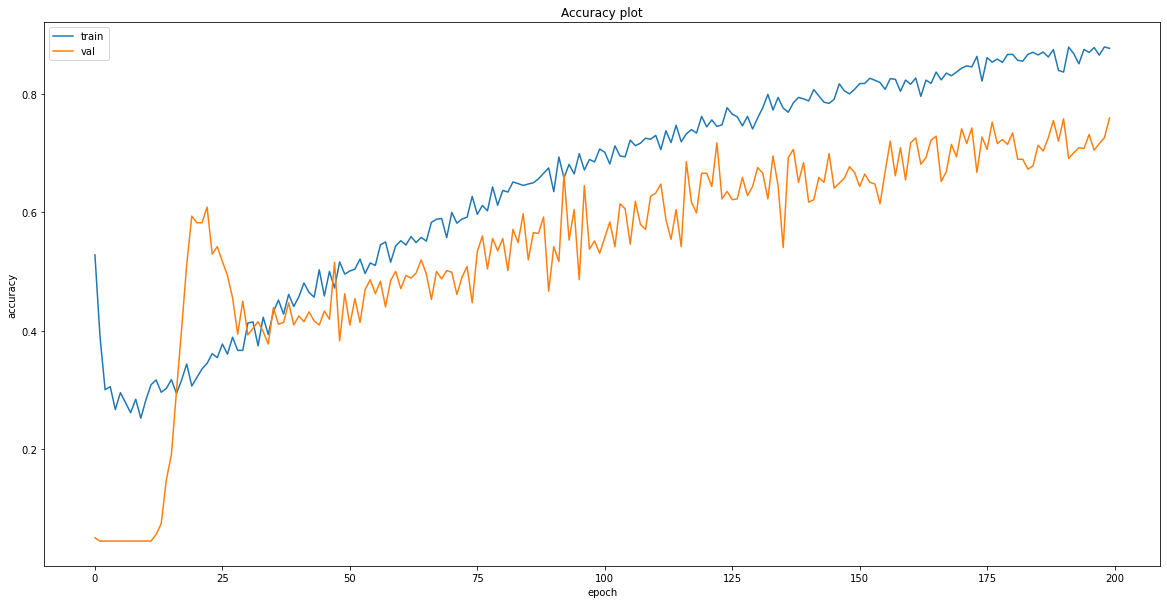

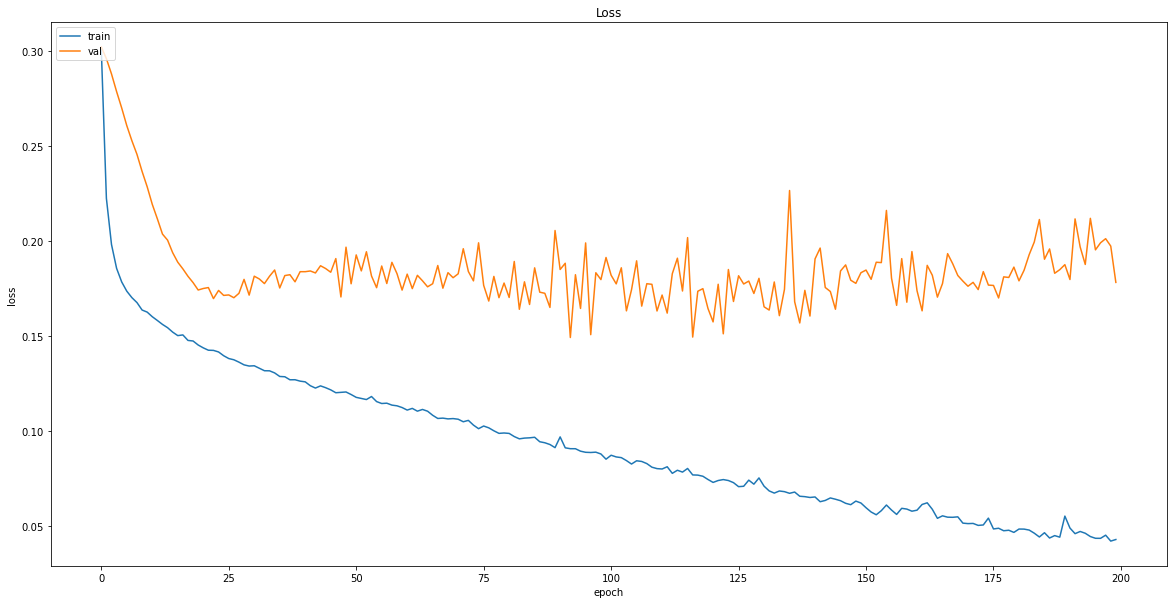

In [126]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [127]:
# Save model
model.save("models/{}".format('cnooc_time_series_lstm_buy_hold_sell_no_ema.model'))

INFO:tensorflow:Assets written to: models/cnooc_time_series_lstm_buy_hold_sell_no_ema.model\assets


### Test Performance

### non-recession

In [128]:
logger = []

In [129]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/0883.HK_data_test.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d     EMA_12   willr_14        OBV_7  labels
Date                                                              
2019-01-22        13.12  12.552209  -3.030323  489168111.0     2.0
2019-01-23        12.94  12.611869 -13.043517  449876554.0     2.0
2019-01-24        12.62  12.613120 -33.333352  395082483.0     2.0
2019-01-25        12.80  12.641871 -37.254896  441807090.0     2.0
2019-01-28        13.06  12.706198 -11.764689  494043477.0     2.0


In [130]:
df.drop(['EMA_12'], axis='columns', inplace=True)

In [131]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1
        
X = sequential
X  = np.array(X).reshape(-1, 15, 3)
y = labels
y = np.array(y)
X.shape

(211, 15, 3)

In [132]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [133]:
model = tf.keras.models.load_model("models/cnooc_time_series_lstm_buy_hold_sell_no_ema.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]);logger.append(score[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.1603 - accuracy: 0.8057 - mean_squared_error: 6.8185 - weighted_accuracy: 0.8057 - weighted_mean_squared_error: 6.8185
Test loss: 0.16034244000911713
Test accuracy: 0.8056871891021729


In [134]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 179, 0: 20, 1: 12})

In [135]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [136]:
df = pd.read_csv("data/cyclic_tickers/initial_indicators/0883.HK_data_test.csv")
df.set_index('Date', inplace=True)

In [137]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2019-02-14,13.46,13.005887,-9.090899,594167146.0,2.0,2,2
2019-02-15,13.28,13.075751,-2.222168,636062191.0,2.0,2,2
2019-02-18,13.68,13.107174,-22.222210,601994876.0,2.0,2,2
2019-02-19,13.76,13.195301,-15.384598,654106730.0,2.0,0,2
2019-02-20,13.92,13.282178,-9.230759,687559434.0,2.0,0,2


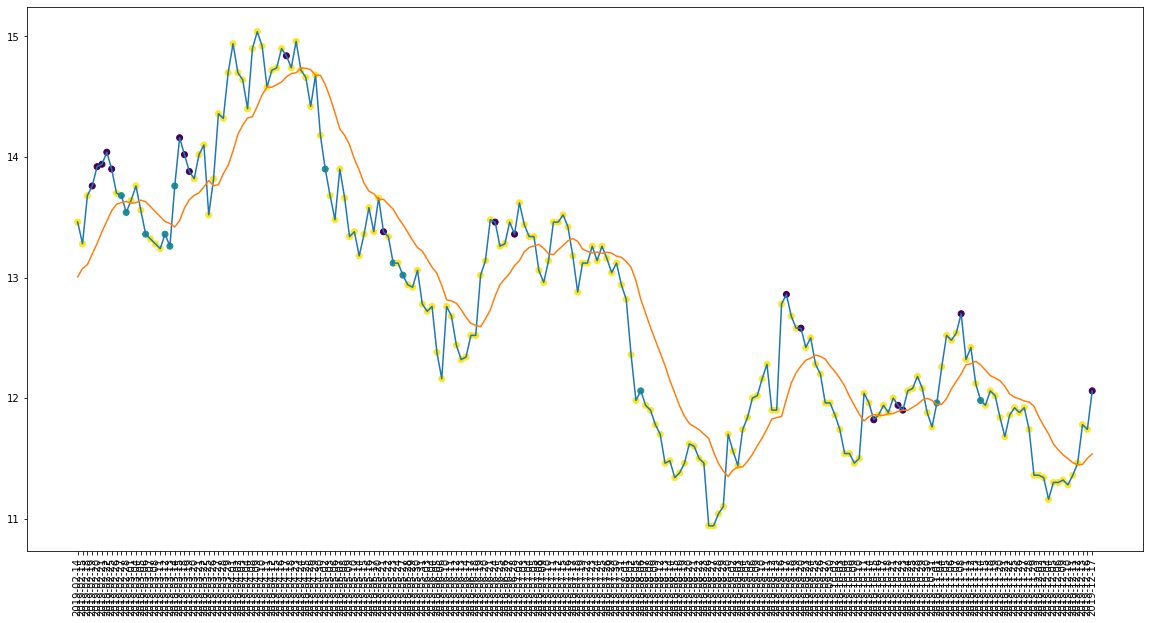

In [138]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

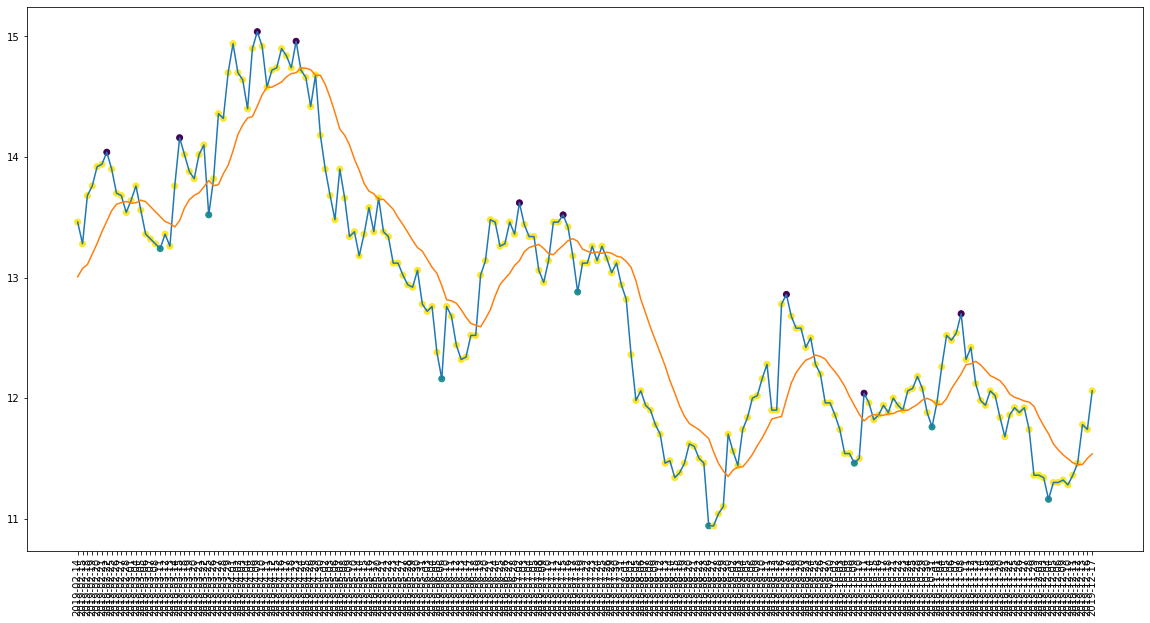

In [139]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [140]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold));logger.append(str(100*buy_buy/buy) + "%");logger.append(str(100*sell_sell/sell) + "%");logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 211
actual predicted buys: 0
actual buys but predicted sell: 0
actual buys but predicted hold: 8
actual sells but predicted buy: 0
actual predicted sells: 4
actual sells but predicted hold: 5
actual holds but predicted buy: 12
actual holds but predicted sell: 16
actual predicted holds: 166
Percentage buys correct: 0.0%
Percentage sells correct: 44.44444444444444%
Percentage holds correct: 85.56701030927834%
actual buys: 8
actual sells: 9
actual holds: 194


In [141]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%");logger.append(str(100*correct_minima/buy) + "%"); logger.append(str(100*correct_maxima/sell) + "%"); logger.append(str(100*correct_hold/hold) + "%")

[13.279999732971193, 13.460000038146973, 13.68000030517578, 13.699999809265135, 13.760000228881836, 13.899999618530273, 13.920000076293945, 13.9399995803833, 14.039999961853027]
[13.359999656677244, 13.539999961853027, 13.5600004196167, 13.640000343322756, 13.68000030517578, 13.699999809265135, 13.760000228881836, 13.899999618530273, 14.039999961853027]
Percentage buys correct: 75.0%
Percentage sells correct: 68.42105263157895%
Percentage holds correct: 82.12290502793296%


In [142]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%');logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $13.68000030517578
Shares owned at the moment: 728
Cash capital at the moment: $13.572417221070282


Stop Loss Activated!

Share price: $13.279999732971193
Shares owned at the moment: 0
Cash capital at the moment: $9654.825663358692


Share price: $13.359999656677244
Shares owned at the moment: 720
Cash capital at the moment: $9.173111230855284


Price increase from previously bought: 5.697357799682012%
Share price: $14.15999984741211
Shares owned at the moment: 0
Cash capital at the moment: $10176.336201669697


Share price: $13.899999618530273
Shares owned at the moment: 730
Cash capital at the moment: $1.4322309083981963


Stop Loss Activated!

Share price: $13.479999542236328
Shares owned at the moment: 0
Cash capital at the moment: $9814.770797659878


Share price: $13.119999885559082
Shares owned at the moment: 746
Cash capital at the moment: $0.3352032675775263


Stop Loss Activated!

Share price: $12.720000267028807
Shares owned at the moment: 0
Cash capital at the

In [143]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%');logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $8912.067081356048
profit gained: -10.879329186439518%


In [144]:
df_length = len(log)
log.loc[df_length] = logger
log.head(20)

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.756881,33.333333333333336%,33.333333333333336%,79.5%,54.54545454545455%,60.0%,80.11695906432749%,-13.971269578518914%,-7.777238176262399%
1,0.725581,25.0%,0.0%,77.77777777777777%,65.71428571428571%,36.36363636363637%,87.57396449704142%,-51.61628959737723%,-48.34563047105195%
2,0.738532,25.0%,0.0%,79.1044776119403%,59.09090909090909%,36.36363636363637%,86.1271676300578%,4.895464871482818%,-5.545324129943856%
3,0.795349,33.333333333333336%,50.0%,83.93782383419689%,52.0%,80.0%,89.08045977011494%,17.65471328540567%,-7.669883276367181%
4,0.805687,0.0%,44.44444444444444%,85.56701030927834%,75.0%,68.42105263157895%,82.12290502793296%,-9.064397011752208%,-10.879329186439518%


### Recession

In [145]:
logger = []

In [146]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/0883.HK_data_test2.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d     EMA_12   willr_14        OBV_7  labels
Date                                                              
2020-01-22        13.00  13.393678 -83.870980  104646165.0     2.0
2020-01-23        13.34  13.385420 -57.377021  145802714.0     2.0
2020-01-24        13.00  13.326125 -85.245880   96260120.0     2.0
2020-01-29        13.04  13.282106 -80.645176  122828433.0     2.0
2020-01-30        12.46  13.155628 -90.804605   53693706.0     2.0


In [147]:
df.drop(['EMA_12'], axis='columns', inplace=True)

In [148]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1
        
X = sequential
X  = np.array(X).reshape(-1, 15, 3)
y = labels
y = np.array(y)
X.shape

(213, 15, 3)

In [149]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [150]:
model = tf.keras.models.load_model("models/cnooc_time_series_lstm_buy_hold_sell_no_ema.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]);logger.append(score[1])

7/7 [==============================] - 0s 4ms/step - loss: 0.1670 - accuracy: 0.7324 - mean_squared_error: 6.4608 - weighted_accuracy: 0.7324 - weighted_mean_squared_error: 6.4608
Test loss: 0.16704770922660828
Test accuracy: 0.7323943376541138


In [151]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 168, 1: 18, 0: 27})

In [152]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [153]:
df = pd.read_csv("data/cyclic_tickers/initial_indicators/0883.HK_data_test2.csv")
df.set_index('Date', inplace=True)

In [154]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2020-02-13,12.34,12.385912,-50.526328,113135355.0,2.0,2,2
2020-02-14,12.34,12.378849,-50.588221,60757697.0,2.0,2,2
2020-02-17,12.26,12.372872,-46.153851,60757697.0,2.0,2,2
2020-02-18,12.00,12.355507,-38.709648,5146960.0,2.0,2,2
2020-02-19,12.08,12.300814,-59.677412,-52626865.0,2.0,2,2


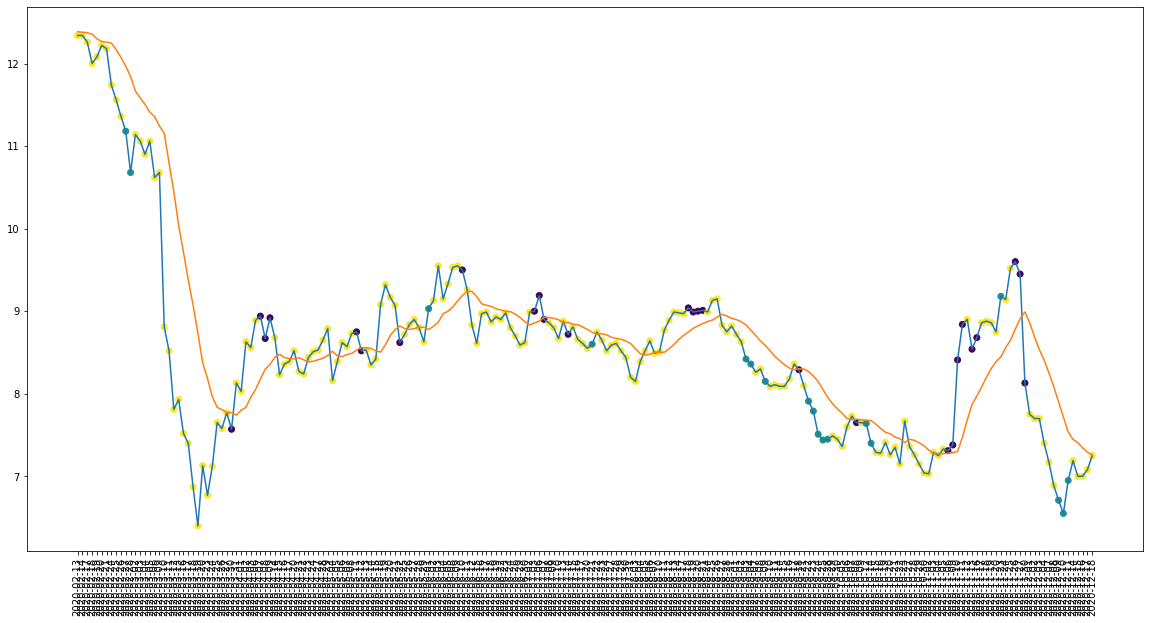

In [155]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

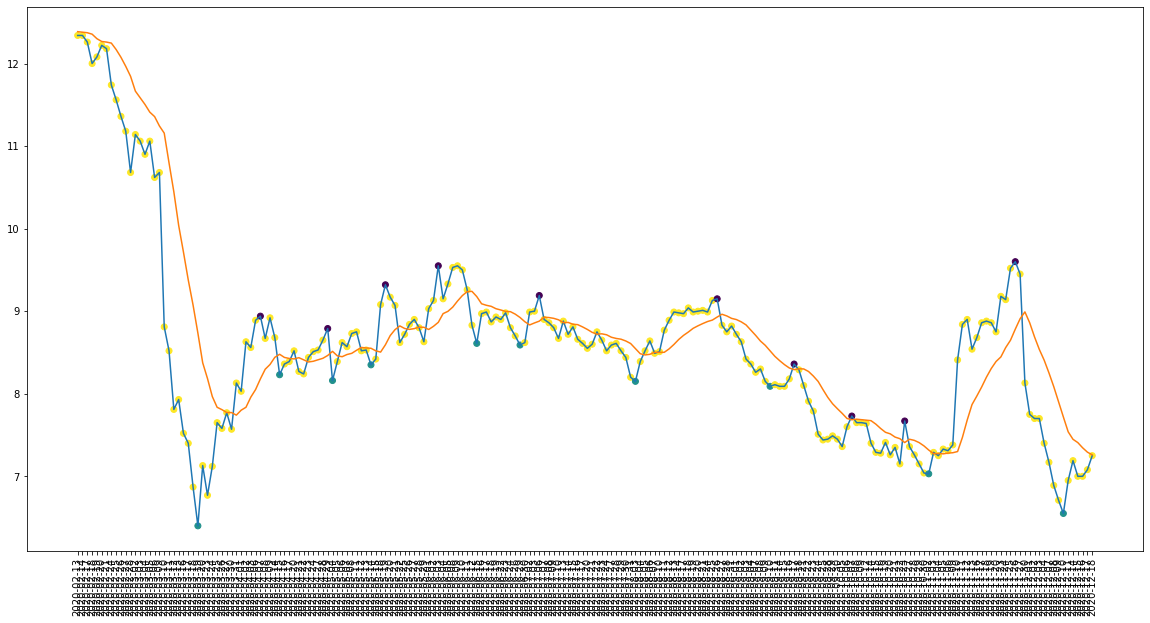

In [156]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [157]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold));logger.append(str(100*buy_buy/buy) + "%");logger.append(str(100*sell_sell/sell) + "%");logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 213
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 9
actual sells but predicted buy: 0
actual predicted sells: 3
actual sells but predicted hold: 7
actual holds but predicted buy: 17
actual holds but predicted sell: 24
actual predicted holds: 152
Percentage buys correct: 10.0%
Percentage sells correct: 30.0%
Percentage holds correct: 78.75647668393782%
actual buys: 10
actual sells: 10
actual holds: 193


In [158]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%");logger.append(str(100*correct_minima/buy) + "%"); logger.append(str(100*correct_maxima/sell) + "%"); logger.append(str(100*correct_hold/hold) + "%")

[11.5600004196167, 11.739999771118164, 12.0, 12.079999923706055, 12.18000030517578, 12.220000267028807, 12.260000228881836, 12.34000015258789, 12.34000015258789]
[10.68000030517578, 10.899999618530273, 11.0600004196167, 11.140000343322754, 11.18000030517578, 11.359999656677244, 11.5600004196167, 11.739999771118164, 12.18000030517578]
Percentage buys correct: 44.44444444444444%
Percentage sells correct: 51.851851851851855%
Percentage holds correct: 82.63473053892216%


In [159]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%');logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $11.18000030517578
Shares owned at the moment: 892
Cash capital at the moment: $0.015187034608970862


Stop Loss Activated!

Share price: $10.68000030517578
Shares owned at the moment: 0
Cash capital at the moment: $9500.377418502807


Share price: $10.68000030517578
Shares owned at the moment: 887
Cash capital at the moment: $1.1659570674910356


Stop Loss Activated!

Share price: $8.8100004196167
Shares owned at the moment: 0
Cash capital at the moment: $7794.146535743953


Share price: $9.029999732971193
Shares owned at the moment: 860
Cash capital at the moment: $6.99081602024944


Stop Loss Activated!

Share price: $8.609999656677246
Shares owned at the moment: 0
Cash capital at the moment: $7391.227871574639


Share price: $8.600000381469728
Shares owned at the moment: 857
Cash capital at the moment: $0.7594937560525068


Stop Loss Activated!

Share price: $8.199999809265138
Shares owned at the moment: 0
Cash capital at the moment: $7008.8339807457905


Share price: 

In [160]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%');logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $5843.750896369933
profit gained: -41.56249103630067%


In [161]:
df_length = len(log)
log.loc[df_length] = logger
log.head(20)

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.756881,33.333333333333336%,33.333333333333336%,79.5%,54.54545454545455%,60.0%,80.11695906432749%,-13.971269578518914%,-7.777238176262399%
1,0.725581,25.0%,0.0%,77.77777777777777%,65.71428571428571%,36.36363636363637%,87.57396449704142%,-51.61628959737723%,-48.34563047105195%
2,0.738532,25.0%,0.0%,79.1044776119403%,59.09090909090909%,36.36363636363637%,86.1271676300578%,4.895464871482818%,-5.545324129943856%
3,0.795349,33.333333333333336%,50.0%,83.93782383419689%,52.0%,80.0%,89.08045977011494%,17.65471328540567%,-7.669883276367181%
4,0.805687,0.0%,44.44444444444444%,85.56701030927834%,75.0%,68.42105263157895%,82.12290502793296%,-9.064397011752208%,-10.879329186439518%
5,0.732394,10.0%,30.0%,78.75647668393782%,44.44444444444444%,51.851851851851855%,82.63473053892216%,-43.80574162069561%,-41.56249103630067%


## JP Morgan

In [162]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/jpm_data.csv")
print(df.head())

         Date  previous_1d     EMA_12   willr_14       OBV_7  labels
0  2000-01-21    49.375000  48.388499 -42.592593  -2894250.0     2.0
1  2000-01-24    48.625000  48.424884 -39.516144  -8054850.0     2.0
2  2000-01-25    48.666668  48.462081 -38.709668  -1595700.0     2.0
3  2000-01-26    49.750000  48.660222 -17.741956   5984250.0     2.0
4  2000-01-27    52.291668  49.218906  -5.232557  14370900.0     2.0


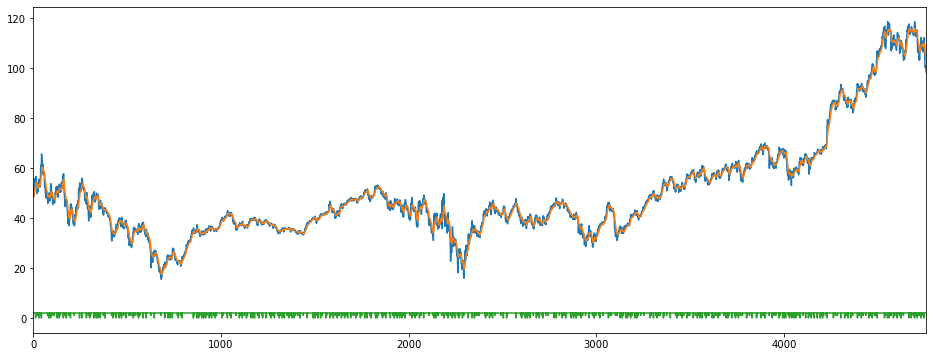

In [163]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [164]:
df.set_index('Date', inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2000-01-21,49.375000,48.388499,-42.592593,-2894250.0,2.0
2000-01-24,48.625000,48.424884,-39.516144,-8054850.0,2.0
2000-01-25,48.666668,48.462081,-38.709668,-1595700.0,2.0
2000-01-26,49.750000,48.660222,-17.741956,5984250.0,2.0
2000-01-27,52.291668,49.218906,-5.232557,14370900.0,2.0


In [165]:
df.drop(['EMA_12'], axis='columns', inplace=True)

In [166]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1
        
X = sequential
X  = np.array(X).reshape(-1, 15, 3)
y = labels
y = np.array(y)
X.shape

(4745, 15, 3)

In [167]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [168]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [169]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [170]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [171]:
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa
opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

#tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "LSTM_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    shuffle = True,
    validation_data=(validation_x, validation_y),
    #callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Epoch 1/200
30/30 [==============================] - 1s 36ms/step - loss: 0.2804 - accuracy: 0.4945 - mse: 0.4847 - weighted_accuracy: 0.3825 - weighted_mse: 0.5361 - val_loss: 0.3007 - val_accuracy: 0.0453 - val_mse: 0.3484 - val_weighted_accuracy: 0.0453 - val_weighted_mse: 0.3484
Epoch 2/200
30/30 [==============================] - 0s 10ms/step - loss: 0.2096 - accuracy: 0.3232 - mse: 0.7776 - weighted_accuracy: 0.4461 - weighted_mse: 0.7648 - val_loss: 0.2913 - val_accuracy: 0.0453 - val_mse: 0.3760 - val_weighted_accuracy: 0.0453 - val_weighted_mse: 0.3760
Epoch 3/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1889 - accuracy: 0.2916 - mse: 0.9908 - weighted_accuracy: 0.4845 - weighted_mse: 0.9673 - val_loss: 0.2800 - val_accuracy: 0.0453 - val_mse: 0.4114 - val_weighted_accuracy: 0.0453 - val_weighted_mse: 0.4114
Epoch 4/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1807 - accuracy: 0.2669 - mse: 1.1311 - weighted_accuracy: 0.5093 - weig

Epoch 30/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1356 - accuracy: 0.3978 - mse: 1.7124 - weighted_accuracy: 0.7170 - weighted_mse: 1.6403 - val_loss: 0.1844 - val_accuracy: 0.4152 - val_mse: 1.6615 - val_weighted_accuracy: 0.4152 - val_weighted_mse: 1.6615
Epoch 31/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1348 - accuracy: 0.4083 - mse: 1.7377 - weighted_accuracy: 0.7114 - weighted_mse: 1.6754 - val_loss: 0.1895 - val_accuracy: 0.3783 - val_mse: 1.7565 - val_weighted_accuracy: 0.3783 - val_weighted_mse: 1.7565
Epoch 32/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1342 - accuracy: 0.4152 - mse: 1.7511 - weighted_accuracy: 0.7292 - weighted_mse: 1.6915 - val_loss: 0.1860 - val_accuracy: 0.4110 - val_mse: 1.6308 - val_weighted_accuracy: 0.4110 - val_weighted_mse: 1.6308
Epoch 33/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1337 - accuracy: 0.3967 - mse: 1.7583 - weighted_accuracy: 0.7149 - weig

Epoch 59/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1121 - accuracy: 0.5717 - mse: 2.1149 - weighted_accuracy: 0.8110 - weighted_mse: 2.1099 - val_loss: 0.1762 - val_accuracy: 0.5026 - val_mse: 2.2560 - val_weighted_accuracy: 0.5026 - val_weighted_mse: 2.2560
Epoch 60/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1118 - accuracy: 0.5695 - mse: 2.1466 - weighted_accuracy: 0.8028 - weighted_mse: 2.1483 - val_loss: 0.1769 - val_accuracy: 0.4984 - val_mse: 2.1470 - val_weighted_accuracy: 0.4984 - val_weighted_mse: 2.1470
Epoch 61/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1109 - accuracy: 0.5624 - mse: 2.1392 - weighted_accuracy: 0.8077 - weighted_mse: 2.1265 - val_loss: 0.1726 - val_accuracy: 0.5184 - val_mse: 2.2365 - val_weighted_accuracy: 0.5184 - val_weighted_mse: 2.2365
Epoch 62/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1107 - accuracy: 0.5645 - mse: 2.1912 - weighted_accuracy: 0.8082 - weig

Epoch 88/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0915 - accuracy: 0.6860 - mse: 2.6729 - weighted_accuracy: 0.8622 - weighted_mse: 2.7169 - val_loss: 0.1627 - val_accuracy: 0.6101 - val_mse: 2.7901 - val_weighted_accuracy: 0.6101 - val_weighted_mse: 2.7901
Epoch 89/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0896 - accuracy: 0.6926 - mse: 2.7388 - weighted_accuracy: 0.8608 - weighted_mse: 2.7825 - val_loss: 0.1525 - val_accuracy: 0.6481 - val_mse: 2.6782 - val_weighted_accuracy: 0.6481 - val_weighted_mse: 2.6782
Epoch 90/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0876 - accuracy: 0.6868 - mse: 2.7947 - weighted_accuracy: 0.8626 - weighted_mse: 2.8421 - val_loss: 0.1776 - val_accuracy: 0.5511 - val_mse: 2.9445 - val_weighted_accuracy: 0.5511 - val_weighted_mse: 2.9445
Epoch 91/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0877 - accuracy: 0.7021 - mse: 2.8014 - weighted_accuracy: 0.8700 - weig

Epoch 117/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0718 - accuracy: 0.7753 - mse: 3.5954 - weighted_accuracy: 0.9084 - weighted_mse: 3.5902 - val_loss: 0.1750 - val_accuracy: 0.6259 - val_mse: 4.0329 - val_weighted_accuracy: 0.6259 - val_weighted_mse: 4.0329
Epoch 118/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0712 - accuracy: 0.7700 - mse: 3.6997 - weighted_accuracy: 0.9046 - weighted_mse: 3.7108 - val_loss: 0.1672 - val_accuracy: 0.6533 - val_mse: 4.0881 - val_weighted_accuracy: 0.6533 - val_weighted_mse: 4.0881
Epoch 119/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0698 - accuracy: 0.7742 - mse: 3.7194 - weighted_accuracy: 0.9079 - weighted_mse: 3.7194 - val_loss: 0.1583 - val_accuracy: 0.6670 - val_mse: 3.9376 - val_weighted_accuracy: 0.6670 - val_weighted_mse: 3.9376
Epoch 120/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0676 - accuracy: 0.7840 - mse: 3.6825 - weighted_accuracy: 0.9116 - 

Epoch 146/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0542 - accuracy: 0.8430 - mse: 4.7858 - weighted_accuracy: 0.9333 - weighted_mse: 4.6366 - val_loss: 0.1705 - val_accuracy: 0.7028 - val_mse: 5.0861 - val_weighted_accuracy: 0.7028 - val_weighted_mse: 5.0861
Epoch 147/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0554 - accuracy: 0.8340 - mse: 4.8403 - weighted_accuracy: 0.9375 - weighted_mse: 4.6657 - val_loss: 0.1701 - val_accuracy: 0.7123 - val_mse: 5.1306 - val_weighted_accuracy: 0.7123 - val_weighted_mse: 5.1306
Epoch 148/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0529 - accuracy: 0.8448 - mse: 4.8721 - weighted_accuracy: 0.9395 - weighted_mse: 4.6514 - val_loss: 0.1695 - val_accuracy: 0.6944 - val_mse: 5.1862 - val_weighted_accuracy: 0.6944 - val_weighted_mse: 5.1862
Epoch 149/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0544 - accuracy: 0.8414 - mse: 4.9350 - weighted_accuracy: 0.9265 - 

Epoch 175/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0398 - accuracy: 0.8920 - mse: 6.3699 - weighted_accuracy: 0.9586 - weighted_mse: 5.8433 - val_loss: 0.1775 - val_accuracy: 0.7482 - val_mse: 6.9624 - val_weighted_accuracy: 0.7482 - val_weighted_mse: 6.9624
Epoch 176/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0429 - accuracy: 0.8751 - mse: 6.4109 - weighted_accuracy: 0.9467 - weighted_mse: 5.8974 - val_loss: 0.1756 - val_accuracy: 0.7460 - val_mse: 6.9850 - val_weighted_accuracy: 0.7460 - val_weighted_mse: 6.9850
Epoch 177/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0422 - accuracy: 0.8870 - mse: 6.5213 - weighted_accuracy: 0.9474 - weighted_mse: 5.9349 - val_loss: 0.1743 - val_accuracy: 0.7619 - val_mse: 7.3542 - val_weighted_accuracy: 0.7619 - val_weighted_mse: 7.3542
Epoch 178/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0408 - accuracy: 0.8944 - mse: 6.5644 - weighted_accuracy: 0.9594 - 

In [172]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1]);logger.append(score[1])

Test loss: 0.21031998097896576
Test accuracy: 0.7312961220741272


In [173]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-1.6194446  -3.3758447   0.55926424]
 [-1.7782623  -4.057296    1.3775243 ]
 [-2.2235827  -7.0211287   1.4458559 ]
 ...
 [-1.9901385  -3.0664258   0.7888686 ]
 [-0.6155287  -2.9013767  -0.86893165]
 [-1.9250062  -4.2408676   1.4713082 ]]


Counter({2: 757, 0: 109, 1: 83})

In [174]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 865, 0: 41, 1: 43})

In [175]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold));logger.append(str(100*buy_buy/buy) + "%");logger.append(str(100*sell_sell/sell) + "%");logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 949
actual predicted buys: 3
actual buys but predicted sell: 1
actual buys but predicted hold: 39
actual sells but predicted buy: 0
actual predicted sells: 7
actual sells but predicted hold: 34
actual holds but predicted buy: 80
actual holds but predicted sell: 101
actual predicted holds: 684
Percentage buys correct: 6.976744186046512%
Percentage sells correct: 17.073170731707318%
Percentage holds correct: 79.07514450867052%
actual buys: 43
actual sells: 41
actual holds: 865


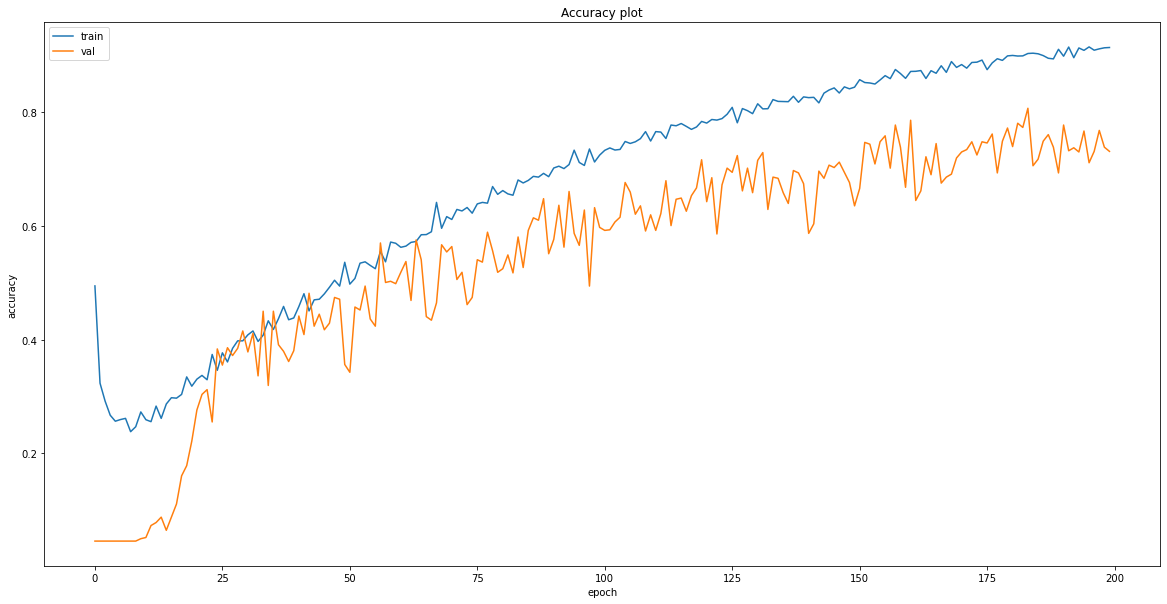

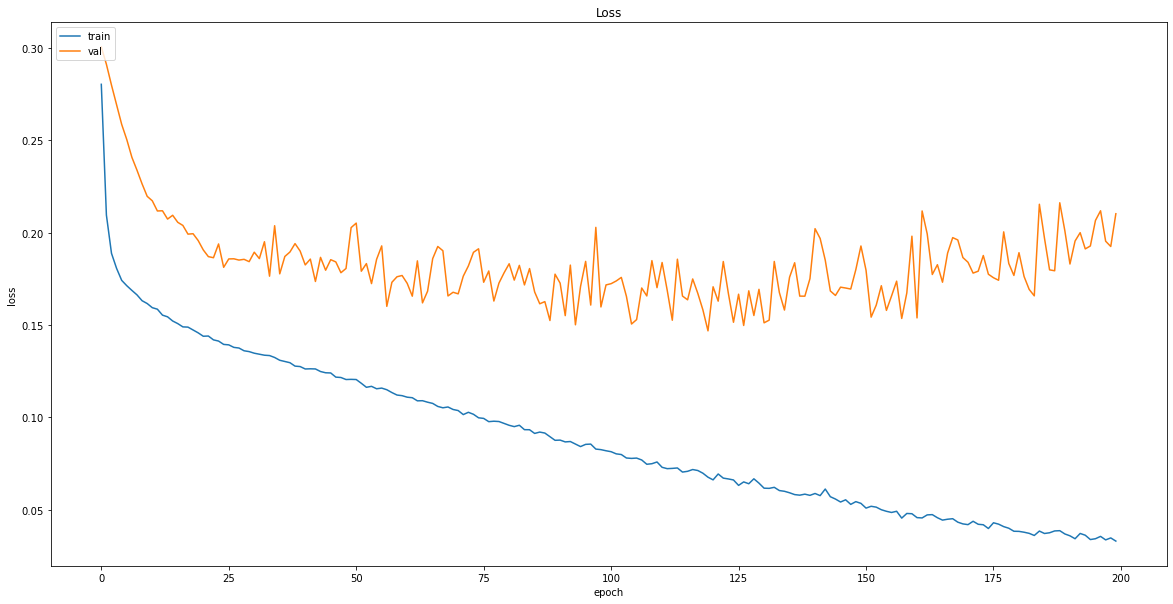

In [176]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [177]:
# Save model
model.save("models/{}".format('jpm_time_series_lstm_buy_hold_sell_no_ema.model'))

INFO:tensorflow:Assets written to: models/jpm_time_series_lstm_buy_hold_sell_no_ema.model\assets


### Test Performance

### non-recession

In [178]:
logger = []

In [179]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/jpm_data_test.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d      EMA_12   willr_14       OBV_7  labels
Date                                                              
2019-01-22   104.589996  101.198442  -3.459880  84335200.0     2.0
2019-01-23   102.940002  101.466374 -21.874992  67251500.0     2.0
2019-01-24   102.680000  101.653086 -27.040213  55104800.0     2.0
2019-01-25   102.739998  101.820303 -32.628441  66401600.0     2.0
2019-01-28   103.389999  102.061795 -23.968276  80771000.0     2.0


In [180]:
df.drop(['EMA_12'], axis='columns', inplace=True)

In [181]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1
        
X = sequential
X  = np.array(X).reshape(-1, 15, 3)
y = labels
y = np.array(y)
X.shape

(218, 15, 3)

In [182]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [183]:
model = tf.keras.models.load_model("models/jpm_time_series_lstm_buy_hold_sell_no_ema.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]);logger.append(score[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.1946 - accuracy: 0.6972 - mean_squared_error: 8.5570 - weighted_accuracy: 0.6972 - weighted_mean_squared_error: 8.5570
Test loss: 0.19458188116550446
Test accuracy: 0.6972476840019226


In [184]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 163, 0: 37, 1: 18})

In [185]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [186]:
df = pd.read_csv("data/cyclic_tickers/initial_indicators/jpm_data_test.csv")
df.set_index('Date', inplace=True)

In [187]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2019-02-11,100.879997,102.975915,-74.903417,73097300.0,1.0,2,1
2019-02-12,102.599998,102.653466,-84.169891,62118800.0,2.0,2,2
2019-02-13,103.089996,102.645240,-50.965236,74971100.0,2.0,2,2
2019-02-14,102.419998,102.713664,-41.505819,85725200.0,2.0,2,2
2019-02-15,105.550003,102.668485,-54.440145,74206700.0,2.0,2,2


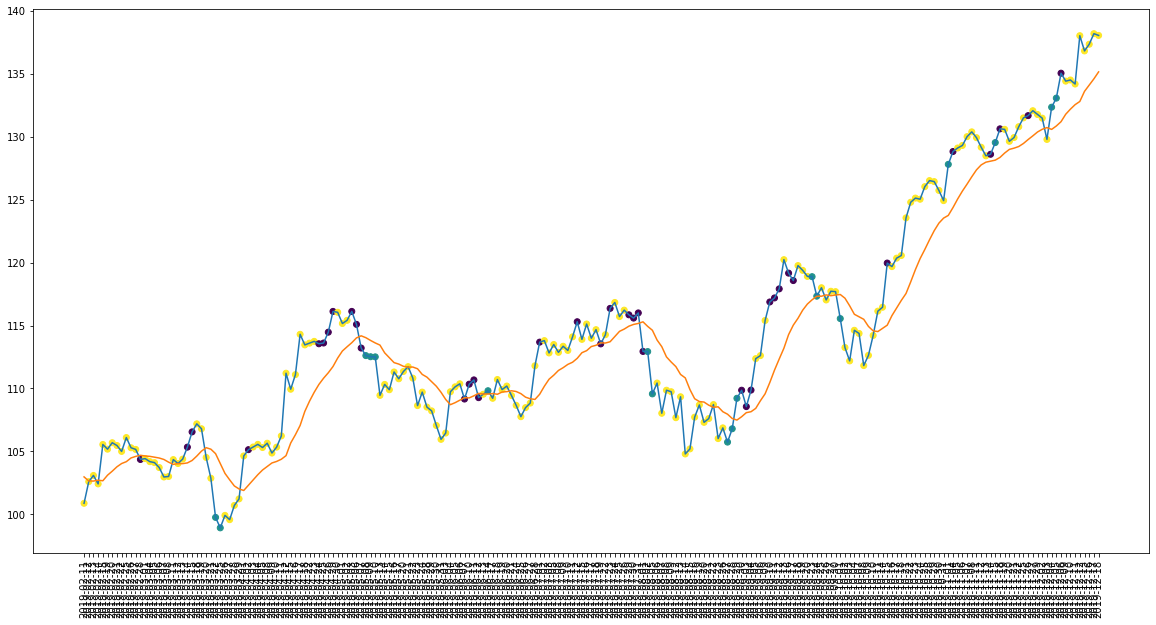

In [188]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

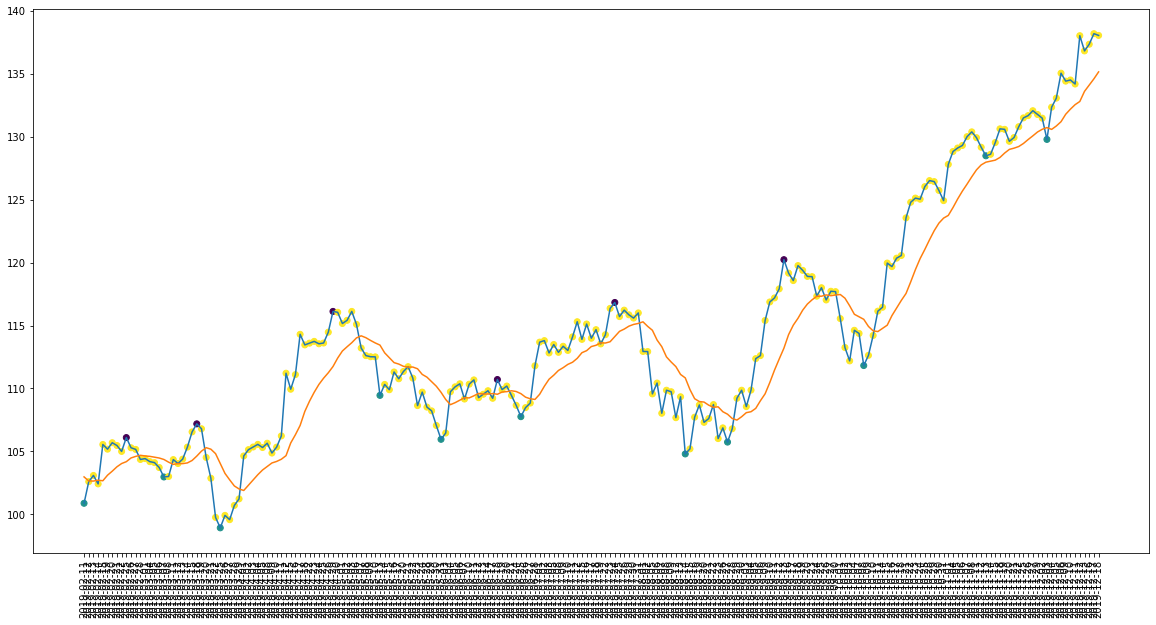

In [189]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [190]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold));logger.append(str(100*buy_buy/buy) + "%");logger.append(str(100*sell_sell/sell) + "%");logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 218
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 9
actual sells but predicted buy: 0
actual predicted sells: 1
actual sells but predicted hold: 5
actual holds but predicted buy: 16
actual holds but predicted sell: 36
actual predicted holds: 149
Percentage buys correct: 18.181818181818183%
Percentage sells correct: 16.666666666666668%
Percentage holds correct: 74.12935323383084%
actual buys: 11
actual sells: 6
actual holds: 201


In [191]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%");logger.append(str(100*correct_minima/buy) + "%"); logger.append(str(100*correct_maxima/sell) + "%"); logger.append(str(100*correct_hold/hold) + "%")

[100.87999725341795, 102.41999816894531, 102.5999984741211, 103.08999633789062, 105.0, 105.18000030517578, 105.47000122070312, 105.5500030517578, 105.69000244140624]
[104.19000244140624, 104.36000061035156, 104.43000030517578, 105.0, 105.16000366210938, 105.29000091552734, 105.47000122070312, 105.69000244140624, 106.0999984741211]
Percentage buys correct: 44.44444444444444%
Percentage sells correct: 43.24324324324324%
Percentage holds correct: 85.18518518518519%


In [192]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%');logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $99.76000213623048
Shares owned at the moment: 99
Cash capital at the moment: $96.6001279315933


Price increase from previously bought: 5.1039044574216375%
Share price: $105.13999938964844
Shares owned at the moment: 0
Cash capital at the moment: $10476.835702672957


Share price: $112.61000061035156
Shares owned at the moment: 92
Cash capital at the moment: $88.22531636619351


Stop Loss Activated!

Share price: $109.4499969482422
Shares owned at the moment: 0
Cash capital at the moment: $10129.934186376571


Share price: $109.81999969482422
Shares owned at the moment: 91
Cash capital at the moment: $108.83175922393639


Price increase from previously bought: 5.664622555411314%
Share price: $116.36000061035156
Shares owned at the moment: 0
Cash capital at the moment: $10668.472724613188


Share price: $112.93000030517578
Shares owned at the moment: 94
Cash capital at the moment: $23.860290847776923


Stop Loss Activated!

Share price: $109.56999969482422
Shares owned at 

In [193]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%');logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $13577.290673755644
profit gained: 35.77290673755644%


In [194]:
df_length = len(log)
log.loc[df_length] = logger
log.head(20)

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.756881,33.333333333333336%,33.333333333333336%,79.5%,54.54545454545455%,60.0%,80.11695906432749%,-13.971269578518914%,-7.777238176262399%
1,0.725581,25.0%,0.0%,77.77777777777777%,65.71428571428571%,36.36363636363637%,87.57396449704142%,-51.61628959737723%,-48.34563047105195%
2,0.738532,25.0%,0.0%,79.1044776119403%,59.09090909090909%,36.36363636363637%,86.1271676300578%,4.895464871482818%,-5.545324129943856%
3,0.795349,33.333333333333336%,50.0%,83.93782383419689%,52.0%,80.0%,89.08045977011494%,17.65471328540567%,-7.669883276367181%
4,0.805687,0.0%,44.44444444444444%,85.56701030927834%,75.0%,68.42105263157895%,82.12290502793296%,-9.064397011752208%,-10.879329186439518%
5,0.732394,10.0%,30.0%,78.75647668393782%,44.44444444444444%,51.851851851851855%,82.63473053892216%,-43.80574162069561%,-41.56249103630067%
6,0.697248,18.181818181818183%,16.666666666666668%,74.12935323383084%,44.44444444444444%,43.24324324324324%,85.18518518518519%,5.601614554729422%,35.77290673755644%


### recession

In [195]:
logger = []

In [196]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/jpm_data_test2.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d      EMA_12   willr_14       OBV_7  labels
Date                                                              
2020-01-22   136.839996  137.690058 -77.454723  33776700.0     2.0
2020-01-23   136.679993  137.534664 -80.363881  26227600.0     2.0
2020-01-24   136.539993  137.381637 -69.867648  16881900.0     2.0
2020-01-27   133.149994  136.730615 -90.166021   1715500.0     1.0
2020-01-28   132.029999  136.007444 -79.004573 -11145000.0     2.0


In [197]:
df.drop(['EMA_12'], axis='columns', inplace=True)

In [198]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1
        
X = sequential
X  = np.array(X).reshape(-1, 15, 3)
y = labels
y = np.array(y)
X.shape

(219, 15, 3)

In [199]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [200]:
model = tf.keras.models.load_model("models/jpm_time_series_lstm_buy_hold_sell_no_ema.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]);logger.append(score[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.2089 - accuracy: 0.6941 - mean_squared_error: 7.7307 - weighted_accuracy: 0.6941 - weighted_mean_squared_error: 7.7307
Test loss: 0.20886118710041046
Test accuracy: 0.6940639019012451


In [201]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 166, 0: 25, 1: 28})

In [202]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [203]:
df = pd.read_csv("data/cyclic_tickers/initial_indicators/jpm_data_test2.csv")
df.set_index('Date', inplace=True)

In [204]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2020-02-11,138.000000,136.179383,-6.410124,26757600.0,0.0,2,0
2020-02-12,138.000000,136.459478,-9.001177,33336200.0,2.0,0,2
2020-02-13,137.880005,136.696481,-13.465502,33336200.0,2.0,0,2
2020-02-14,137.460007,136.878562,-14.718062,25888700.0,2.0,0,2
2020-02-18,135.639999,136.968015,-23.401387,19261100.0,2.0,1,2


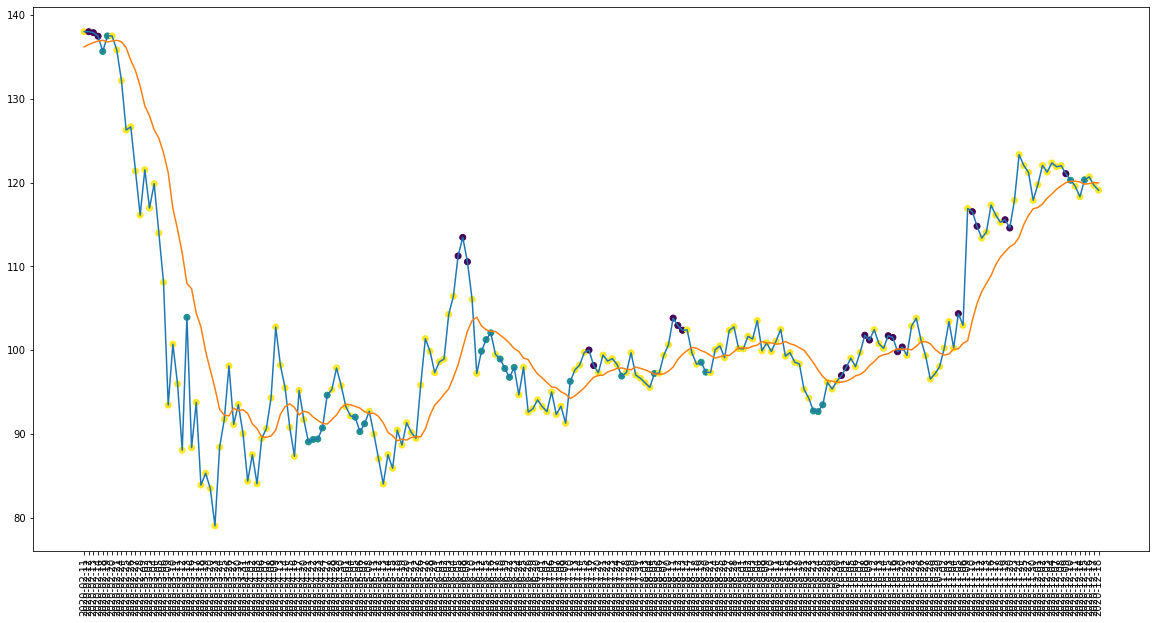

In [205]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

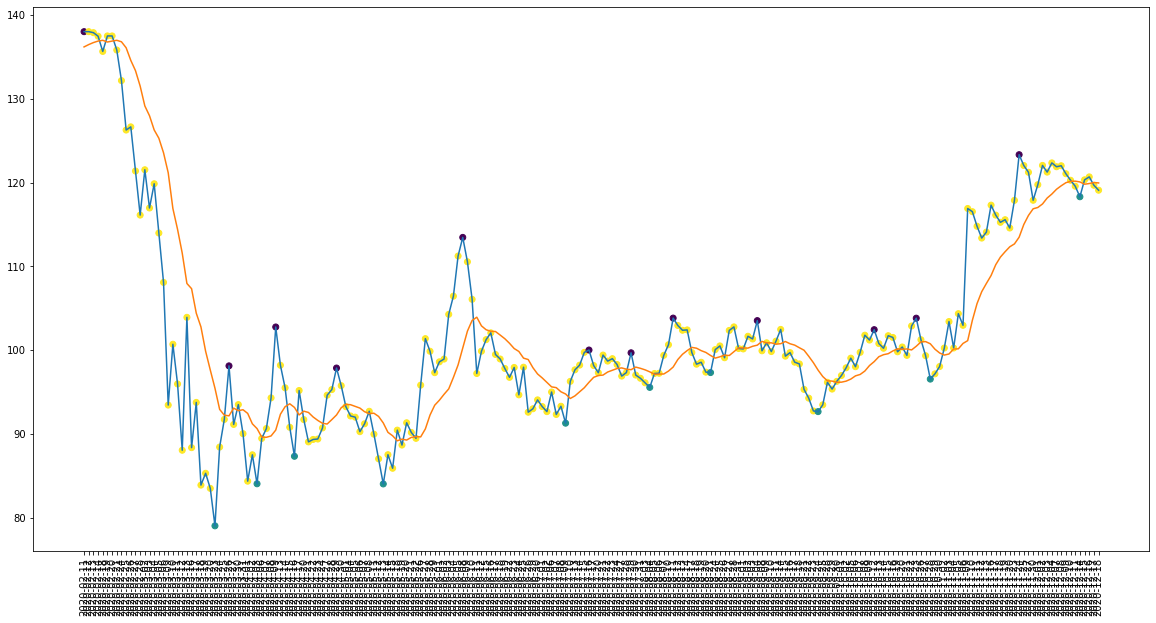

In [206]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [207]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold));logger.append(str(100*buy_buy/buy) + "%");logger.append(str(100*sell_sell/sell) + "%");logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 219
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 9
actual sells but predicted buy: 0
actual predicted sells: 3
actual sells but predicted hold: 9
actual holds but predicted buy: 27
actual holds but predicted sell: 22
actual predicted holds: 148
Percentage buys correct: 10.0%
Percentage sells correct: 25.0%
Percentage holds correct: 75.1269035532995%
actual buys: 10
actual sells: 12
actual holds: 197


In [208]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%");logger.append(str(100*correct_minima/buy) + "%"); logger.append(str(100*correct_maxima/sell) + "%"); logger.append(str(100*correct_hold/hold) + "%")

[132.16000366210938, 135.63999938964844, 135.80999755859378, 137.46000671386722, 137.49000549316406, 137.49000549316406, 137.8800048828125, 138.0, 138.0]
[116.11000061035156, 116.95999908447266, 121.37000274658205, 121.5199966430664, 126.26000213623048, 126.63999938964844, 132.16000366210938, 135.80999755859378, 137.49000549316406]
Percentage buys correct: 60.714285714285715%
Percentage sells correct: 64.0%
Percentage holds correct: 81.81818181818181%


In [209]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%');logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $135.63999938964844
Shares owned at the moment: 73
Cash capital at the moment: $71.05031467819208


Stop Loss Activated!

Share price: $126.26000213623048
Shares owned at the moment: 0
Cash capital at the moment: $9262.68377519417


Share price: $103.91000366210938
Shares owned at the moment: 88
Cash capital at the moment: $93.45723204231399


Stop Loss Activated!

Share price: $88.36000061035156
Shares owned at the moment: 0
Cash capital at the moment: $7847.754165605546


Share price: $89.05000305175781
Shares owned at the moment: 87
Cash capital at the moment: $79.09868687248309


Stop Loss Activated!

Share price: $84.02999877929688
Shares owned at the moment: 0
Cash capital at the moment: $7369.604403463364


Share price: $99.87000274658205
Shares owned at the moment: 73
Cash capital at the moment: $59.04529991149866


Stop Loss Activated!

Share price: $96.75
Shares owned at the moment: 0
Cash capital at the moment: $7102.372737411499


Share price: $96.75
Shares own

In [210]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%');logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $8586.858291473387
profit gained: -14.13141708526613%


In [211]:
df_length = len(log)
log.loc[df_length] = logger
log.head(20)

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.756881,33.333333333333336%,33.333333333333336%,79.5%,54.54545454545455%,60.0%,80.11695906432749%,-13.971269578518914%,-7.777238176262399%
1,0.725581,25.0%,0.0%,77.77777777777777%,65.71428571428571%,36.36363636363637%,87.57396449704142%,-51.61628959737723%,-48.34563047105195%
2,0.738532,25.0%,0.0%,79.1044776119403%,59.09090909090909%,36.36363636363637%,86.1271676300578%,4.895464871482818%,-5.545324129943856%
3,0.795349,33.333333333333336%,50.0%,83.93782383419689%,52.0%,80.0%,89.08045977011494%,17.65471328540567%,-7.669883276367181%
4,0.805687,0.0%,44.44444444444444%,85.56701030927834%,75.0%,68.42105263157895%,82.12290502793296%,-9.064397011752208%,-10.879329186439518%
5,0.732394,10.0%,30.0%,78.75647668393782%,44.44444444444444%,51.851851851851855%,82.63473053892216%,-43.80574162069561%,-41.56249103630067%
6,0.697248,18.181818181818183%,16.666666666666668%,74.12935323383084%,44.44444444444444%,43.24324324324324%,85.18518518518519%,5.601614554729422%,35.77290673755644%
7,0.694064,10.0%,25.0%,75.1269035532995%,60.714285714285715%,64.0%,81.81818181818181%,-27.887322019443513%,-14.13141708526613%


## American Axle & Manufacturing Holdings, Inc

In [212]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/AXL_data.csv")
print(df.head())

         Date  previous_1d     EMA_12   willr_14     OBV_7  labels
0  2000-01-21      16.0625  14.895987 -18.478261  298700.0     2.0
1  2000-01-24      15.8750  15.046605 -22.222222  293100.0     2.0
2  2000-01-25      15.7500  15.154819 -26.190476  286300.0     2.0
3  2000-01-26      15.7500  15.246386 -29.729730  286300.0     2.0
4  2000-01-27      16.0000  15.362326 -25.000000  311700.0     0.0


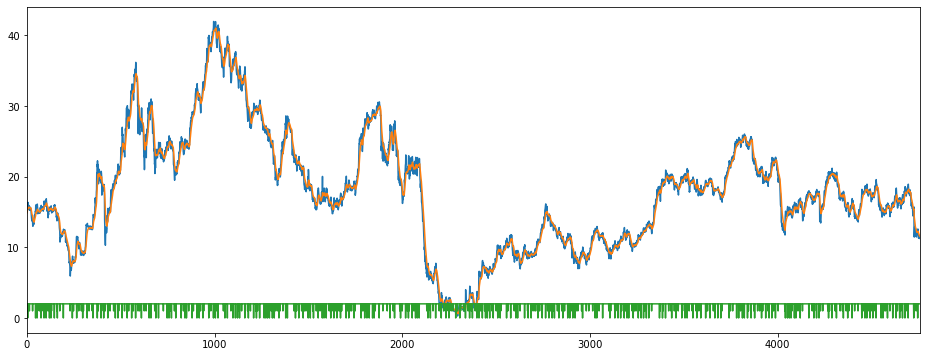

In [213]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [214]:
df.set_index('Date', inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2000-01-21,16.0625,14.895987,-18.478261,298700.0,2.0
2000-01-24,15.8750,15.046605,-22.222222,293100.0,2.0
2000-01-25,15.7500,15.154819,-26.190476,286300.0,2.0
2000-01-26,15.7500,15.246386,-29.729730,286300.0,2.0
2000-01-27,16.0000,15.362326,-25.000000,311700.0,0.0


In [215]:
df.drop(['EMA_12'], axis='columns', inplace=True)

In [216]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1
        
X = sequential
X  = np.array(X).reshape(-1, 15, 3)
y = labels
y = np.array(y)
X.shape

(4745, 15, 3)

In [217]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [218]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [219]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [220]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [221]:
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa
opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

#tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "LSTM_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    shuffle = True,
    validation_data=(validation_x, validation_y),
    #callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 0 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Epoch 1/200
30/30 [==============================] - 1s 30ms/step - loss: 0.2864 - accuracy: 0.4984 - mse: 0.4769 - weighted_accuracy: 0.3672 - weighted_mse: 0.5443 - val_loss: 0.3009 - val_accuracy: 0.0464 - val_mse: 0.3492 - val_weighted_accuracy: 0.0464 - val_weighted_mse: 0.3492
Epoch 2/200
30/30 [==============================] - 0s 7ms/step - loss: 0.2130 - accuracy: 0.2803 - mse: 0.8037 - weighted_accuracy: 0.4150 - weighted_mse: 0.7912 - val_loss: 0.2919 - val_accuracy: 0.0464 - val_mse: 0.3798 - val_weighted_accuracy: 0.0464 - val_weighted_mse: 0.3798
Epoch 3/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1930 - accuracy: 0.2566 - mse: 1.0031 - weighted_accuracy: 0.4555 - weighted_mse: 0.9805 - val_loss: 0.2800 - val_accuracy: 0.0464 - val_mse: 0.4164 - val_weighted_accuracy: 0.0464 - val_weighted_mse: 0.4164
Epoch 4/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1835 - accuracy: 0.2637 - mse: 1.1302 - weighted_accuracy: 0.5110 - weighte

Epoch 30/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1388 - accuracy: 0.3783 - mse: 1.5998 - weighted_accuracy: 0.6989 - weighted_mse: 1.5228 - val_loss: 0.1898 - val_accuracy: 0.3667 - val_mse: 1.6285 - val_weighted_accuracy: 0.3667 - val_weighted_mse: 1.6285
Epoch 31/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1385 - accuracy: 0.4025 - mse: 1.5977 - weighted_accuracy: 0.7060 - weighted_mse: 1.5277 - val_loss: 0.1916 - val_accuracy: 0.3425 - val_mse: 1.6392 - val_weighted_accuracy: 0.3425 - val_weighted_mse: 1.6392
Epoch 32/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1369 - accuracy: 0.3625 - mse: 1.6427 - weighted_accuracy: 0.7004 - weighted_mse: 1.5579 - val_loss: 0.1901 - val_accuracy: 0.3572 - val_mse: 1.6057 - val_weighted_accuracy: 0.3572 - val_weighted_mse: 1.6057
Epoch 33/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1358 - accuracy: 0.3875 - mse: 1.6458 - weighted_accuracy: 0.6969 - weig

Epoch 59/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1142 - accuracy: 0.5514 - mse: 2.0976 - weighted_accuracy: 0.8008 - weighted_mse: 2.0964 - val_loss: 0.1823 - val_accuracy: 0.4805 - val_mse: 2.1114 - val_weighted_accuracy: 0.4805 - val_weighted_mse: 2.1114
Epoch 60/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1138 - accuracy: 0.5358 - mse: 2.1176 - weighted_accuracy: 0.7969 - weighted_mse: 2.1126 - val_loss: 0.1813 - val_accuracy: 0.4921 - val_mse: 2.1655 - val_weighted_accuracy: 0.4921 - val_weighted_mse: 2.1655
Epoch 61/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1129 - accuracy: 0.5767 - mse: 2.1307 - weighted_accuracy: 0.8119 - weighted_mse: 2.1343 - val_loss: 0.1813 - val_accuracy: 0.4816 - val_mse: 2.1253 - val_weighted_accuracy: 0.4816 - val_weighted_mse: 2.1253
Epoch 62/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1119 - accuracy: 0.5379 - mse: 2.1798 - weighted_accuracy: 0.8013 - weig

Epoch 88/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0907 - accuracy: 0.6884 - mse: 2.7147 - weighted_accuracy: 0.8656 - weighted_mse: 2.7894 - val_loss: 0.1611 - val_accuracy: 0.6070 - val_mse: 2.8840 - val_weighted_accuracy: 0.6070 - val_weighted_mse: 2.8840
Epoch 89/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0908 - accuracy: 0.6999 - mse: 2.6907 - weighted_accuracy: 0.8644 - weighted_mse: 2.7717 - val_loss: 0.1843 - val_accuracy: 0.5437 - val_mse: 2.9967 - val_weighted_accuracy: 0.5437 - val_weighted_mse: 2.9967
Epoch 90/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0899 - accuracy: 0.6718 - mse: 2.7695 - weighted_accuracy: 0.8632 - weighted_mse: 2.8661 - val_loss: 0.1584 - val_accuracy: 0.6607 - val_mse: 2.9631 - val_weighted_accuracy: 0.6607 - val_weighted_mse: 2.9631
Epoch 91/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0882 - accuracy: 0.7005 - mse: 2.7536 - weighted_accuracy: 0.8700 - weig

Epoch 117/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0726 - accuracy: 0.7624 - mse: 3.5820 - weighted_accuracy: 0.9019 - weighted_mse: 3.7036 - val_loss: 0.1809 - val_accuracy: 0.6238 - val_mse: 3.9655 - val_weighted_accuracy: 0.6238 - val_weighted_mse: 3.9655
Epoch 118/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0725 - accuracy: 0.7655 - mse: 3.6538 - weighted_accuracy: 0.8994 - weighted_mse: 3.7852 - val_loss: 0.1626 - val_accuracy: 0.6849 - val_mse: 3.6048 - val_weighted_accuracy: 0.6849 - val_weighted_mse: 3.6048
Epoch 119/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0716 - accuracy: 0.7848 - mse: 3.6628 - weighted_accuracy: 0.9083 - weighted_mse: 3.8057 - val_loss: 0.1729 - val_accuracy: 0.6291 - val_mse: 3.7563 - val_weighted_accuracy: 0.6291 - val_weighted_mse: 3.7563
Epoch 120/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0716 - accuracy: 0.7734 - mse: 3.6719 - weighted_accuracy: 0.9114 - 

Epoch 146/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0584 - accuracy: 0.8243 - mse: 4.7400 - weighted_accuracy: 0.9301 - weighted_mse: 4.8271 - val_loss: 0.1817 - val_accuracy: 0.6733 - val_mse: 5.0218 - val_weighted_accuracy: 0.6733 - val_weighted_mse: 5.0218
Epoch 147/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0606 - accuracy: 0.8151 - mse: 4.6584 - weighted_accuracy: 0.9176 - weighted_mse: 4.7814 - val_loss: 0.1850 - val_accuracy: 0.6754 - val_mse: 4.4305 - val_weighted_accuracy: 0.6754 - val_weighted_mse: 4.4305
Epoch 148/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0552 - accuracy: 0.8398 - mse: 4.7243 - weighted_accuracy: 0.9376 - weighted_mse: 4.8037 - val_loss: 0.1712 - val_accuracy: 0.7197 - val_mse: 5.0376 - val_weighted_accuracy: 0.7197 - val_weighted_mse: 5.0376
Epoch 149/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0545 - accuracy: 0.8425 - mse: 4.7874 - weighted_accuracy: 0.9404 - 

Epoch 175/200
30/30 [==============================] - 0s 9ms/step - loss: 0.0451 - accuracy: 0.8712 - mse: 6.2070 - weighted_accuracy: 0.9455 - weighted_mse: 6.1981 - val_loss: 0.2282 - val_accuracy: 0.6544 - val_mse: 6.2777 - val_weighted_accuracy: 0.6544 - val_weighted_mse: 6.2777
Epoch 176/200
30/30 [==============================] - 0s 9ms/step - loss: 0.0470 - accuracy: 0.8714 - mse: 6.3142 - weighted_accuracy: 0.9419 - weighted_mse: 6.2806 - val_loss: 0.2032 - val_accuracy: 0.7050 - val_mse: 6.4957 - val_weighted_accuracy: 0.7050 - val_weighted_mse: 6.4957
Epoch 177/200
30/30 [==============================] - 0s 8ms/step - loss: 0.0467 - accuracy: 0.8693 - mse: 6.2772 - weighted_accuracy: 0.9466 - weighted_mse: 6.2645 - val_loss: 0.1909 - val_accuracy: 0.7439 - val_mse: 6.8264 - val_weighted_accuracy: 0.7439 - val_weighted_mse: 6.8264
Epoch 178/200
30/30 [==============================] - 0s 8ms/step - loss: 0.0426 - accuracy: 0.8844 - mse: 6.3824 - weighted_accuracy: 0.9521 - 

In [222]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1]);logger.append(score[1])

Test loss: 0.21926575899124146
Test accuracy: 0.7302423715591431


In [223]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-4.4194436  -3.054372    3.0199418 ]
 [ 0.47286278 -5.2742324  -1.3543748 ]
 [-6.05085     0.759762   -0.72953963]
 ...
 [-3.5540707  -0.86206144 -0.11083631]
 [-0.6117055  -2.8528945   0.45974275]
 [-5.2553496  -2.0989716   1.524343  ]]


Counter({2: 748, 0: 87, 1: 114})

In [224]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 862, 0: 43, 1: 44})

In [225]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold));logger.append(str(100*buy_buy/buy) + "%");logger.append(str(100*sell_sell/sell) + "%");logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 949
actual predicted buys: 10
actual buys but predicted sell: 1
actual buys but predicted hold: 33
actual sells but predicted buy: 1
actual predicted sells: 5
actual sells but predicted hold: 37
actual holds but predicted buy: 103
actual holds but predicted sell: 81
actual predicted holds: 678
Percentage buys correct: 22.727272727272727%
Percentage sells correct: 11.627906976744185%
Percentage holds correct: 78.65429234338747%
actual buys: 44
actual sells: 43
actual holds: 862


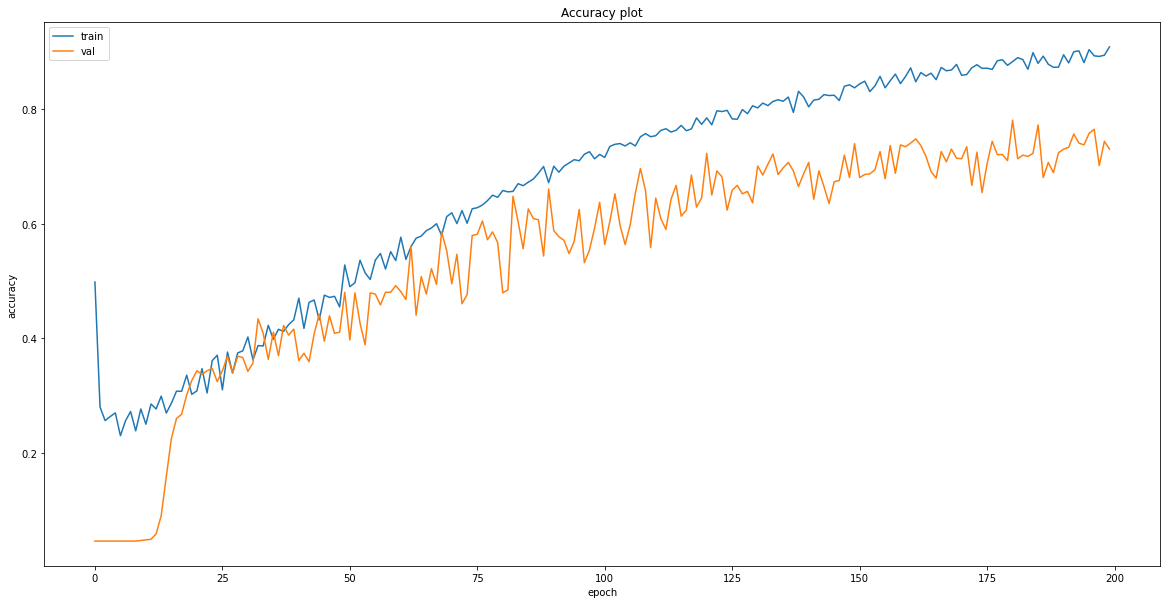

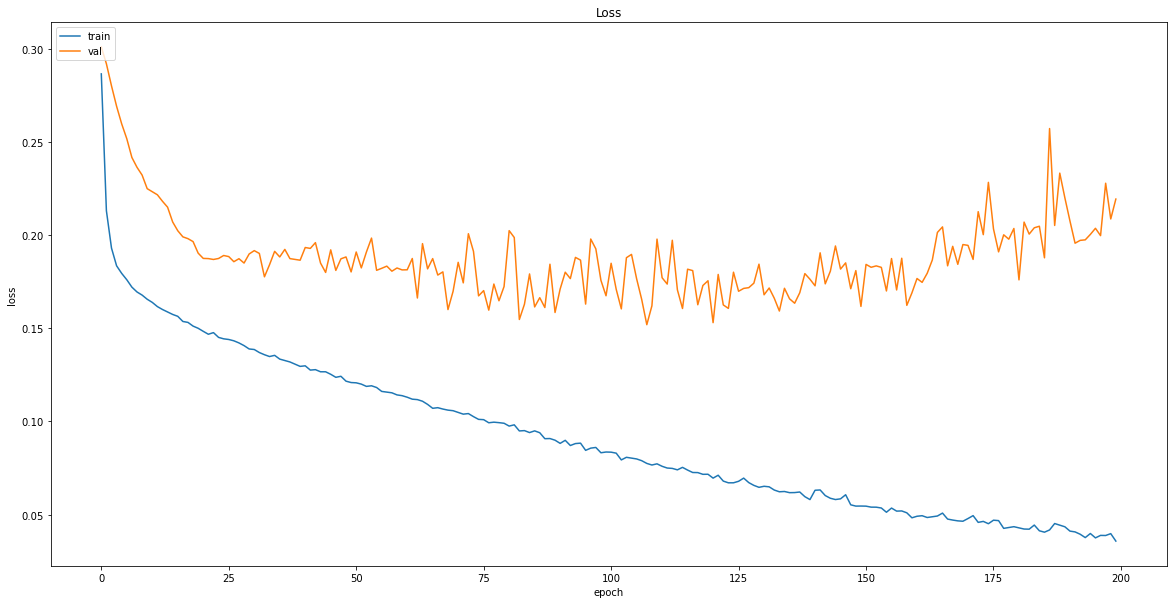

In [226]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [227]:
# Save model
model.save("models/{}".format('axl_time_series_lstm_buy_hold_sell_no_ema.model'))

INFO:tensorflow:Assets written to: models/axl_time_series_lstm_buy_hold_sell_no_ema.model\assets


### Test Performance

### non-recession

In [228]:
logger = []

In [229]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/AXL_data_test.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2019-01-22        14.61  13.028180  -0.258404  23356600.0     2.0
2019-01-23        14.52  13.257691  -3.886001  21174700.0     2.0
2019-01-24        14.18  13.399585 -13.535906  19629300.0     2.0
2019-01-25        14.38  13.550418  -8.579880  20903300.0     2.0
2019-01-28        14.71  13.728815  -4.790414  22287500.0     2.0


In [230]:
df.drop(['EMA_12'], axis='columns', inplace=True)

In [231]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1
        
X = sequential
X  = np.array(X).reshape(-1, 15, 3)
y = labels
y = np.array(y)
X.shape

(218, 15, 3)

In [232]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [233]:
model = tf.keras.models.load_model("models/axl_time_series_lstm_buy_hold_sell_no_ema.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]);logger.append(score[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.2524 - accuracy: 0.6560 - mean_squared_error: 8.3162 - weighted_accuracy: 0.6560 - weighted_mean_squared_error: 8.3162
Test loss: 0.25244447588920593
Test accuracy: 0.6559633016586304


In [234]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({1: 42, 2: 151, 0: 25})

In [235]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [236]:
df = pd.read_csv("data/cyclic_tickers/initial_indicators/AXL_data_test.csv")
df.set_index('Date', inplace=True)

In [237]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2019-02-11,14.01,14.312907,-83.060094,17347800.0,2.0,1,2
2019-02-12,14.34,14.266306,-68.852439,19189100.0,2.0,2,2
2019-02-13,14.45,14.277643,-50.819664,21493700.0,2.0,2,2
2019-02-14,14.70,14.304160,-44.808757,23008200.0,2.0,2,2
2019-02-15,16.83,14.365058,-31.147561,25735200.0,2.0,2,2


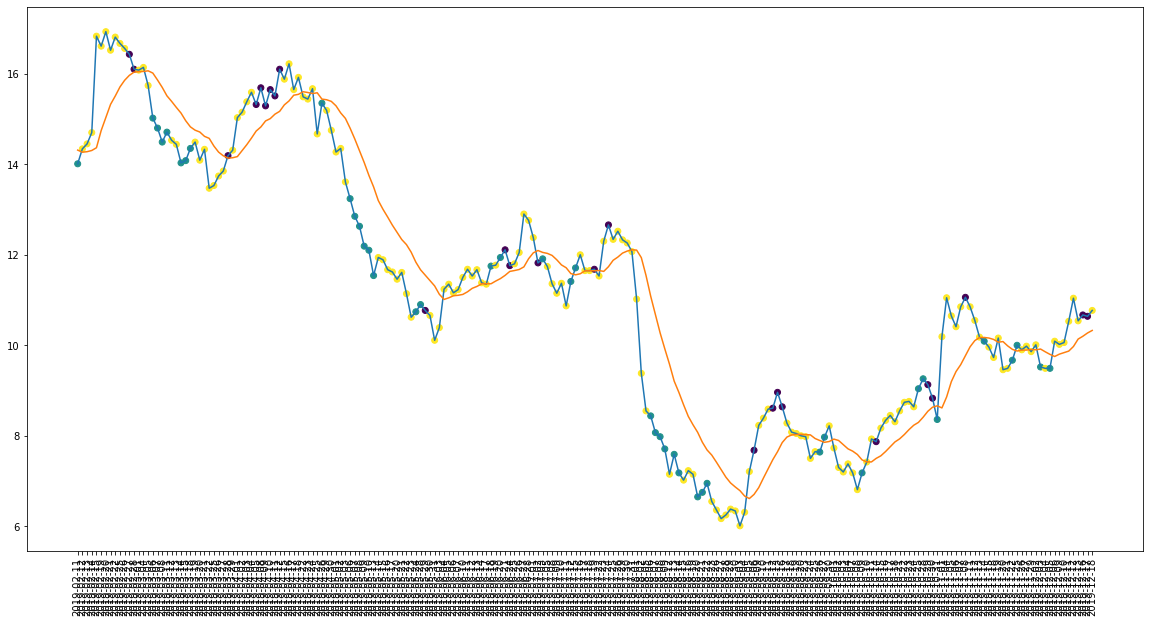

In [238]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

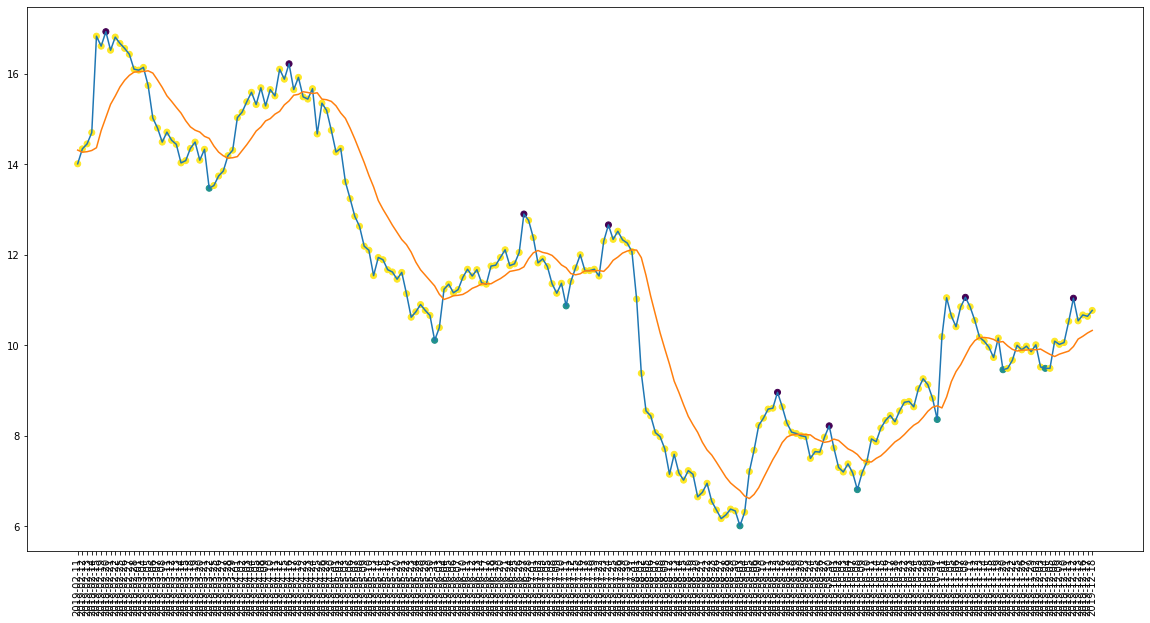

In [239]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [240]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold));logger.append(str(100*buy_buy/buy) + "%");logger.append(str(100*sell_sell/sell) + "%");logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 218
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 7
actual sells but predicted buy: 0
actual predicted sells: 3
actual sells but predicted hold: 5
actual holds but predicted buy: 41
actual holds but predicted sell: 22
actual predicted holds: 139
Percentage buys correct: 12.5%
Percentage sells correct: 37.5%
Percentage holds correct: 68.81188118811882%
actual buys: 8
actual sells: 8
actual holds: 202


In [241]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%");logger.append(str(100*correct_minima/buy) + "%"); logger.append(str(100*correct_maxima/sell) + "%"); logger.append(str(100*correct_hold/hold) + "%")

[14.010000228881836, 14.34000015258789, 14.449999809265135, 14.699999809265135, 16.520000457763672, 16.610000610351562, 16.809999465942386, 16.829999923706055, 16.930000305175778]
[16.079999923706055, 16.100000381469727, 16.139999389648438, 16.430000305175778, 16.520000457763672, 16.559999465942386, 16.670000076293945, 16.809999465942386, 16.930000305175778]
Percentage buys correct: 33.333333333333336%
Percentage sells correct: 48.0%
Percentage holds correct: 85.33333333333333%


In [242]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%');logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $14.010000228881836
Shares owned at the moment: 711
Cash capital at the moment: $11.496784317492711


Price increase from previously bought: 16.951759084774686%
Share price: $16.430000305175778
Shares owned at the moment: 0
Cash capital at the moment: $11661.102243200776


Share price: $15.020000457763672
Shares owned at the moment: 774
Cash capital at the moment: $3.6518179173435783


Stop Loss Activated!

Share price: $14.489999771118164
Shares owned at the moment: 0
Cash capital at the moment: $11188.069676249977


Share price: $14.489999771118164
Shares owned at the moment: 770
Cash capital at the moment: $0.08727797364736034


Stop Loss Activated!

Share price: $14.029999732971193
Shares owned at the moment: 0
Cash capital at the moment: $10773.4785479269


Share price: $14.029999732971193
Shares owned at the moment: 765
Cash capital at the moment: $11.013140265697075


Stop Loss Activated!

Share price: $13.470000267028807
Shares owned at the moment: 0
Cash capital a

In [243]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%');logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $7647.909066392421
profit gained: -23.520909336075793%


In [244]:
df_length = len(log)
log.loc[df_length] = logger
log.head(20)

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.756881,33.333333333333336%,33.333333333333336%,79.5%,54.54545454545455%,60.0%,80.11695906432749%,-13.971269578518914%,-7.777238176262399%
1,0.725581,25.0%,0.0%,77.77777777777777%,65.71428571428571%,36.36363636363637%,87.57396449704142%,-51.61628959737723%,-48.34563047105195%
2,0.738532,25.0%,0.0%,79.1044776119403%,59.09090909090909%,36.36363636363637%,86.1271676300578%,4.895464871482818%,-5.545324129943856%
3,0.795349,33.333333333333336%,50.0%,83.93782383419689%,52.0%,80.0%,89.08045977011494%,17.65471328540567%,-7.669883276367181%
4,0.805687,0.0%,44.44444444444444%,85.56701030927834%,75.0%,68.42105263157895%,82.12290502793296%,-9.064397011752208%,-10.879329186439518%
5,0.732394,10.0%,30.0%,78.75647668393782%,44.44444444444444%,51.851851851851855%,82.63473053892216%,-43.80574162069561%,-41.56249103630067%
6,0.697248,18.181818181818183%,16.666666666666668%,74.12935323383084%,44.44444444444444%,43.24324324324324%,85.18518518518519%,5.601614554729422%,35.77290673755644%
7,0.694064,10.0%,25.0%,75.1269035532995%,60.714285714285715%,64.0%,81.81818181818181%,-27.887322019443513%,-14.13141708526613%
8,0.655963,12.5%,37.5%,68.81188118811882%,33.333333333333336%,48.0%,85.33333333333333%,-27.170190438620057%,-23.520909336075793%


### recession

In [245]:
logger = []

In [246]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/AXL_data_test2.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d    EMA_12   willr_14      OBV_7  labels
Date                                                           
2020-01-22         9.39  9.715390 -73.059349 -3592400.0     2.0
2020-01-23         9.34  9.657637 -75.342463 -4550300.0     2.0
2020-01-24         9.50  9.633386 -65.000010 -3092000.0     2.0
2020-01-27         9.31  9.583634 -66.883101 -4332600.0     2.0
2020-01-28         9.39  9.553844 -61.688301 -2300800.0     2.0


In [247]:
df.drop(['EMA_12'], axis='columns', inplace=True)

In [248]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1
        
X = sequential
X  = np.array(X).reshape(-1, 15, 3)
y = labels
y = np.array(y)
X.shape

(219, 15, 3)

In [249]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [250]:
model = tf.keras.models.load_model("models/axl_time_series_lstm_buy_hold_sell_no_ema.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]);logger.append(score[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.1888 - accuracy: 0.7260 - mean_squared_error: 7.3119 - weighted_accuracy: 0.7260 - weighted_mean_squared_error: 7.3119
Test loss: 0.18880216777324677
Test accuracy: 0.7260273694992065


In [251]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 174, 1: 27, 0: 18})

In [252]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [253]:
df = pd.read_csv("data/cyclic_tickers/initial_indicators/AXL_data_test2.csv")
df.set_index('Date', inplace=True)

In [254]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2020-02-11,9.84,9.643918,-57.638900,-3274300.0,2.0,2,2
2020-02-12,10.34,9.674085,-36.805548,-1876100.0,0.0,2,0
2020-02-13,10.22,9.776533,-16.568036,-291400.0,2.0,2,2
2020-02-14,8.77,9.844759,-23.668622,-1567700.0,2.0,2,2
2020-02-18,8.27,9.679411,-90.686248,-6644000.0,2.0,2,2


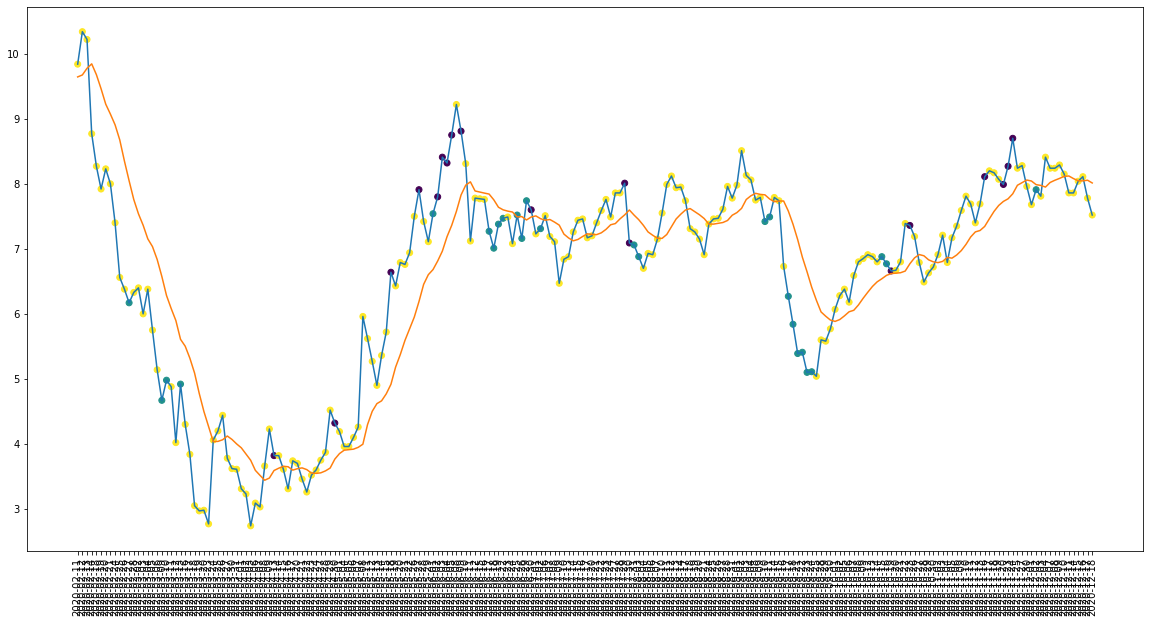

In [255]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

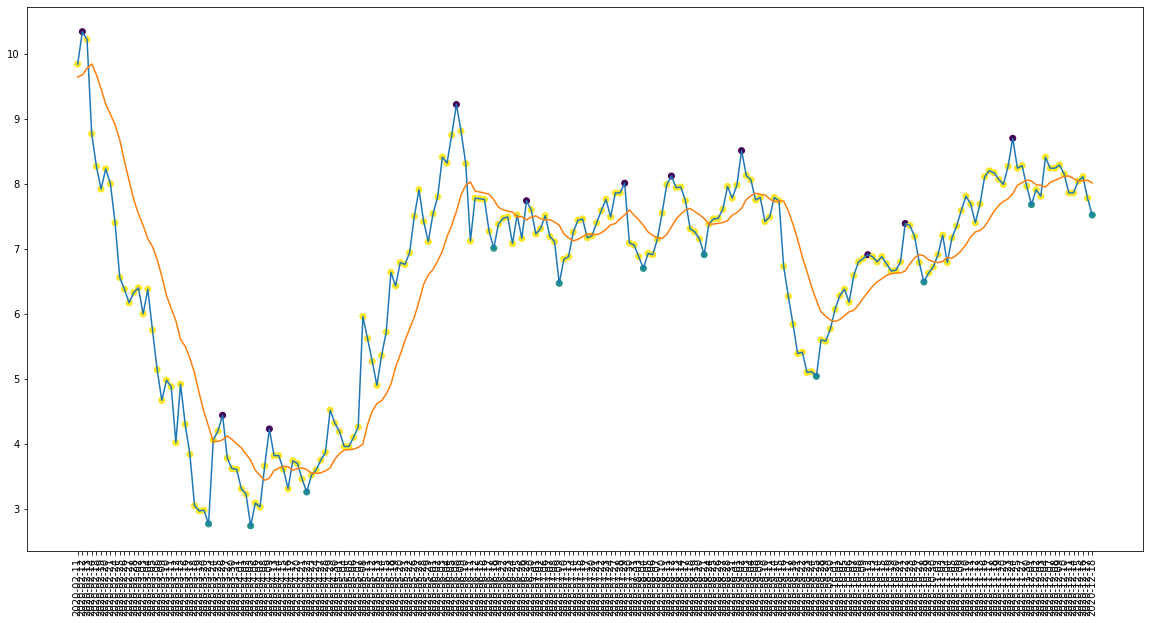

In [256]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [257]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold));logger.append(str(100*buy_buy/buy) + "%");logger.append(str(100*sell_sell/sell) + "%");logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 219
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 10
actual sells but predicted buy: 1
actual predicted sells: 2
actual sells but predicted hold: 8
actual holds but predicted buy: 25
actual holds but predicted sell: 16
actual predicted holds: 156
Percentage buys correct: 9.090909090909092%
Percentage sells correct: 18.181818181818183%
Percentage holds correct: 79.18781725888324%
actual buys: 11
actual sells: 11
actual holds: 197


In [258]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%");logger.append(str(100*correct_minima/buy) + "%"); logger.append(str(100*correct_maxima/sell) + "%"); logger.append(str(100*correct_hold/hold) + "%")

[7.400000095367432, 7.920000076293945, 8.0, 8.229999542236326, 8.270000457763674, 8.770000457763674, 9.84000015258789, 10.220000267028807, 10.34000015258789]
[6.0, 6.170000076293945, 6.329999923706055, 6.380000114440918, 6.4000000953674325, 6.559999942779541, 7.400000095367432, 8.0, 8.229999542236326]
Percentage buys correct: 57.69230769230769%
Percentage sells correct: 72.22222222222223%
Percentage holds correct: 85.05747126436782%


In [259]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%');logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $6.170000076293945
Shares owned at the moment: 1616
Cash capital at the moment: $1.860396369933369


Stop Loss Activated!

Share price: $6.0
Shares owned at the moment: 0
Cash capital at the moment: $9671.196396369933


Share price: $4.670000076293945
Shares owned at the moment: 2065
Cash capital at the moment: $1.1264758896813873


Stop Loss Activated!

Share price: $4.019999980926514
Shares owned at the moment: 0
Cash capital at the moment: $8279.597861611246


Share price: $4.920000076293945
Shares owned at the moment: 1678
Cash capital at the moment: $1.1343932379477337


Stop Loss Activated!

Share price: $4.300000190734863
Shares owned at the moment: 0
Cash capital at the moment: $7196.692362410902


Share price: $7.539999961853027
Shares owned at the moment: 951
Cash capital at the moment: $6.433413788437065


Price increase from previously bought: 11.232570510150897%
Share price: $8.409999847412111
Shares owned at the moment: 0
Cash capital at the moment: $7982.349

In [260]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%');logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $7601.479205735086
profit gained: -23.98520794264914%


In [261]:
df_length = len(log)
log.loc[df_length] = logger
log.head(20)

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.756881,33.333333333333336%,33.333333333333336%,79.5%,54.54545454545455%,60.0%,80.11695906432749%,-13.971269578518914%,-7.777238176262399%
1,0.725581,25.0%,0.0%,77.77777777777777%,65.71428571428571%,36.36363636363637%,87.57396449704142%,-51.61628959737723%,-48.34563047105195%
2,0.738532,25.0%,0.0%,79.1044776119403%,59.09090909090909%,36.36363636363637%,86.1271676300578%,4.895464871482818%,-5.545324129943856%
3,0.795349,33.333333333333336%,50.0%,83.93782383419689%,52.0%,80.0%,89.08045977011494%,17.65471328540567%,-7.669883276367181%
4,0.805687,0.0%,44.44444444444444%,85.56701030927834%,75.0%,68.42105263157895%,82.12290502793296%,-9.064397011752208%,-10.879329186439518%
5,0.732394,10.0%,30.0%,78.75647668393782%,44.44444444444444%,51.851851851851855%,82.63473053892216%,-43.80574162069561%,-41.56249103630067%
6,0.697248,18.181818181818183%,16.666666666666668%,74.12935323383084%,44.44444444444444%,43.24324324324324%,85.18518518518519%,5.601614554729422%,35.77290673755644%
7,0.694064,10.0%,25.0%,75.1269035532995%,60.714285714285715%,64.0%,81.81818181818181%,-27.887322019443513%,-14.13141708526613%
8,0.655963,12.5%,37.5%,68.81188118811882%,33.333333333333336%,48.0%,85.33333333333333%,-27.170190438620057%,-23.520909336075793%
9,0.726027,9.090909090909092%,18.181818181818183%,79.18781725888324%,57.69230769230769%,72.22222222222223%,85.05747126436782%,-33.21761431490427%,-23.98520794264914%


In [262]:
experiment

'No EMA LSTM Time Series - cyclic'

In [263]:
log.to_csv('{}.csv'.format(experiment))